# Universal Spectra Analysis from JETSCAPE MAP Parameters

This notebook computes pT-differential spectra and universal scaled spectra from JETSCAPE (Pb-Pb collisions at 2.76 TeV) using MAP parameters with Chapman-Enskog corrections. 

## **Author:** OptimusThi  
## **Date:** December 2025

### 1. Setup and Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from datetime import datetime

from calculations_file_format_single_event import (
    return_result_dtype, 
    Qn_species, 
    Qn_diff_pT_cuts
)

# For better plots in Jupyter
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

Using idf = 0 : Grad
SystemsInfo = 
{'Pb-Pb-2760': {'proj': 'Pb', 'targ': 'Pb', 'sqrts': 2760, 'run_id': 'production_500pts_Pb_Pb_2760', 'n_design': 500, 'n_validation': 100, 'design_remove_idx': [289, 483, 324, 326, 459, 429, 334, 462, 242, 341, 406, 440, 377, 123, 447], 'npc': 10, 'MAP_obs_file': 'main.dat'}}


### 2. Configuration

In [2]:
# Physical constants
MASS_LIST = np.array([0.13957, 0.49368, 0.93827, 1.18937, 1.32132])  # π, K, p, Σ, Ξ

# pT bins
PT_CUTS = np.array([
    0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6,
    0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0, 1.05, 1.1, 1.15, 1.2, 1.25,
    1.3, 1.35, 1.4, 1.45, 1.5, 1.55, 1.6, 1.65, 1.7, 1.75, 1.8, 1.85, 1.9,
    1.95, 2.0, 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3.0, 3.2, 3.4,
    3.6, 3.8, 4.0, 10.0
])
PT_LIST = (PT_CUTS[1:] + PT_CUTS[:-1]) / 2

# Particles
PARTICLES = {
    'pi': {'id': 0, 'label': r'$\pi$', 'name': 'pion'},
    'ka': {'id': 1, 'label': r'$K$', 'name': 'kaon'},
    'pr': {'id': 2, 'label': r'$p$', 'name': 'proton'},
    'Sigma': {'id': 3, 'label': r'$\Sigma$', 'name': 'Sigma'},
    'Xi': {'id': 4, 'label': r'$\Xi$', 'name': 'Xi'}
}
PARTICLE_ORDER = ['pi', 'ka', 'pr', 'Sigma', 'Xi']

# Centrality bins
CENTRALITY_BINS = [(0, 5), (5, 10), (10, 20), (20, 30), (30, 40), (40, 50), (50, 60)]
CENTRALITY_LABELS = ['0-5%', '5-10%', '10-20%', '20-30%', '30-40%', '40-50%', '50-60%']

# Delta-f correction (1 = Chapman-Enskog)
DELTA_F_INDEX = 1

# Plot styling
COLORS = ['red', 'black', 'blue', 'green', 'orange', 'cyan', 'gray']
MARKERS = ['o', '^', 's', 'v', 'd', 'H', '*']

print(f"Configuration loaded:")
print(f"  - {len(PARTICLES)} particle species")
print(f"  - {len(PT_LIST)} pT bins from {PT_CUTS[0]:.2f} to {PT_CUTS[-1]:.2f} GeV/c")
print(f"  - {len(CENTRALITY_BINS)} centrality bins")

Configuration loaded:
  - 5 particle species
  - 56 pT bins from 0.00 to 10.00 GeV/c
  - 7 centrality bins


### 3. Helper Functions

In [3]:
def configure_matplotlib_style():
    """Set matplotlib parameters for publication-quality plots."""
    params = {
        'xtick.major.size': 6, 'ytick.major.size': 6,
        'xtick.minor.size': 3, 'ytick.minor.size': 3,
        'xtick.major.width': 1.2, 'ytick.major.width': 1.2,
        'xtick.minor.width': 1.0, 'ytick.minor.width': 1.0,
        'axes.linewidth': 1.0, 'lines.linewidth': 1.0,
        'xtick.direction': 'in', 'ytick.direction': 'in',
        'xtick.minor.visible': True, 'ytick.minor.visible': True,
        'font.family': 'serif', 'font.size': 12
    }
    plt.rcParams.update(params)

configure_matplotlib_style()


def get_Q_0(alldata, delta_f_index, pid):
    """Extract Q_0 values (pT spectrum) for a specific particle type."""
    return np.array([event[4][delta_f_index][pid][0] for event in alldata])

def get_nsamples(alldata, delta_f_index):
    """Extract number of samples per hydro event."""
    nsamples = np.array([event[3][delta_f_index][0] for event in alldata], dtype=float)
    nsamples[nsamples == 0] = np.inf
    return nsamples

def sort_by_charged_multiplicity(Qn_norm, n_charged_species=3):
    """Sort events by charged particle multiplicity (descending)."""
    if Qn_norm.ndim == 4:
        charged_mult = 2.0 * np.sum(Qn_norm[:, :n_charged_species, 0, :], axis=(1, 2))
    elif Qn_norm.ndim == 3:
        charged_mult = 2.0 * np.sum(Qn_norm[:, :n_charged_species, :], axis=(1, 2))
    else:
        raise ValueError(f"Expected 3D or 4D array, got {Qn_norm.ndim}D")
    return np.argsort(charged_mult)[::-1]

def select_centrality_groups(eventlist, centrality_bins):
    """Group events into centrality percentile bins."""
    n_events = len(eventlist)
    groups = []
    for low_pct, high_pct in centrality_bins:
        idx_low = int(np.floor(low_pct / 100.0 * n_events))
        idx_high = int(np.floor(high_pct / 100.0 * n_events))
        groups.append(eventlist[idx_low:idx_high])
    return groups

def compute_universal_spectra(dNdpt_cent, pt_bins):
    """
    Compute universal scaling function U(x_T) for a centrality class.
    
    Returns
    -------
    mean_pT : float
        Mean transverse momentum <pT> (GeV/c)
    N : float
        Total multiplicity
    U : np.ndarray
        Universal spectrum U(x_T)
    mean_spectrum : np.ndarray
        Average dN/dpT spectrum
    """
    mean_spectrum = np.mean(dNdpt_cent, axis=0)
    N = np.trapz(mean_spectrum, pt_bins)
    mean_pT = np.trapz(pt_bins * mean_spectrum, pt_bins) / N
    U = mean_pT * mean_spectrum / N
    return mean_pT, N, U, mean_spectrum

print("Helper functions defined ✓")

Helper functions defined ✓


### 4. Load JETSCAPE Data

In [4]:
# Load data
data_file = 'results_recalc_MAP_CE_Pb_2760_fine_pT.dat'
print(f"Loading data from: {data_file}")

result_dtype = return_result_dtype('ALICE')
data = np.fromfile(data_file, dtype=result_dtype)

print(f"✓ Loaded {len(data)} events")

# Get normalization samples
samples = get_nsamples(data, DELTA_F_INDEX)
print(f"✓ Extracted normalization samples")

Loading data from: results_recalc_MAP_CE_Pb_2760_fine_pT.dat


/tmp/ipykernel_10429/2501618078.py:6: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  data = np.fromfile(data_file, dtype=result_dtype)


✓ Loaded 5040 events
✓ Extracted normalization samples


### 5. Process Particle Spectra

In [5]:
print("Processing particle spectra...")

# Extract and normalize spectra for all particles
Qn_norm_all = np.zeros((len(data), len(PARTICLES), len(PT_LIST)))

for particle_name, info in PARTICLES.items():
    pid = info['id']
    Q_0 = get_Q_0(data, DELTA_F_INDEX, pid)
    Qn_norm_all[:, pid, :] = Q_0 / samples[:, np.newaxis] / np.diff(PT_CUTS)
    print(f"  ✓ {info['name']:8s} (pid={pid})")

print("✓ All spectra processed")

Processing particle spectra...
  ✓ pion     (pid=0)
  ✓ kaon     (pid=1)
  ✓ proton   (pid=2)
  ✓ Sigma    (pid=3)
  ✓ Xi       (pid=4)
✓ All spectra processed


### 6. Sort by Centrality

In [6]:
print("Sorting events by charged multiplicity...")
eventlist = sort_by_charged_multiplicity(Qn_norm_all)
cent_groups = select_centrality_groups(eventlist, CENTRALITY_BINS)

print(f"✓ Events sorted into {len(cent_groups)} centrality bins:")
for i, (cent_bin, events) in enumerate(zip(CENTRALITY_BINS, cent_groups)):
    print(f"  {CENTRALITY_LABELS[i]:8s}: {len(events):5d} events")

Sorting events by charged multiplicity...
✓ Events sorted into 7 centrality bins:
  0-5%    :   252 events
  5-10%   :   252 events
  10-20%  :   504 events
  20-30%  :   504 events
  30-40%  :   504 events
  40-50%  :   504 events
  50-60%  :   504 events


### 7. Compute Universal Spectra for All Particles and Centralities

In [7]:
print("Computing universal spectra...")

# Initialize storage dictionaries
results = {
    'differential_spectra': {},  # dN/dpT
    'universal_spectra': {},     # U(x_T)
    'mean_pt': {},               # <pT>
    'multiplicity': {},          # N
    'x_T': {}                    # x_T = pT/<pT>
}

for particle_name in PARTICLE_ORDER:
    pid = PARTICLES[particle_name]['id']
    dNdpt = Qn_norm_all[:, pid, :]
    
    # Initialize arrays for this particle
    n_cent = len(cent_groups)
    n_pt = len(PT_LIST)
    
    results['differential_spectra'][particle_name] = np.zeros((n_cent, n_pt))
    results['universal_spectra'][particle_name] = np.zeros((n_cent, n_pt))
    results['mean_pt'][particle_name] = np.zeros(n_cent)
    results['multiplicity'][particle_name] = np.zeros(n_cent)
    results['x_T'][particle_name] = np.zeros((n_cent, n_pt))
    
    # Compute for each centrality
    for cent_idx, event_indices in enumerate(cent_groups):
        if len(event_indices) == 0:
            print(f"  Warning: No events in centrality {CENTRALITY_LABELS[cent_idx]}, {particle_name}")
            continue
        
        dNdpt_cent = dNdpt[event_indices]
        mean_pT, N, U, mean_spectrum = compute_universal_spectra(dNdpt_cent, PT_LIST)
        
        # Store results
        results['differential_spectra'][particle_name][cent_idx] = mean_spectrum
        results['universal_spectra'][particle_name][cent_idx] = U
        results['mean_pt'][particle_name][cent_idx] = mean_pT
        results['multiplicity'][particle_name][cent_idx] = N
        results['x_T'][particle_name][cent_idx] = PT_LIST / mean_pT
    
    print(f"  ✓ {PARTICLES[particle_name]['name']}")

print("✓ Universal spectra computed for all particles and centralities")

Computing universal spectra...
  ✓ pion
  ✓ kaon
  ✓ proton
  ✓ Sigma
  ✓ Xi
✓ Universal spectra computed for all particles and centralities


### 8. Save Results to NPZ File

In [8]:
# Create output directory
output_dir = Path('output')
output_dir.mkdir(exist_ok=True)

# Prepare data for saving
save_dict = {
    # Metadata
    'metadata/date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'metadata/n_events': len(data),
    'metadata/delta_f_index': DELTA_F_INDEX,
    'metadata/collision_system': 'Pb-Pb @ 2.76 TeV',
    'metadata/model': 'JETSCAPE MAP Chapman-Enskog',
    
    # Configuration
    'config/pt_cuts': PT_CUTS,
    'config/pt_list': PT_LIST,
    'config/centrality_bins': np.array(CENTRALITY_BINS),
    'config/centrality_labels': np.array(CENTRALITY_LABELS),
    'config/particle_order': np.array(PARTICLE_ORDER),
    'config/mass_list': MASS_LIST,
}

# Add particle data
for particle_name in PARTICLE_ORDER:
    prefix = f'particle/{particle_name}'
    save_dict[f'{prefix}/differential_spectra'] = results['differential_spectra'][particle_name]
    save_dict[f'{prefix}/universal_spectra'] = results['universal_spectra'][particle_name]
    save_dict[f'{prefix}/mean_pt'] = results['mean_pt'][particle_name]
    save_dict[f'{prefix}/multiplicity'] = results['multiplicity'][particle_name]
    save_dict[f'{prefix}/x_T'] = results['x_T'][particle_name]
    save_dict[f'{prefix}/label'] = PARTICLES[particle_name]['label']
    save_dict[f'{prefix}/full_name'] = PARTICLES[particle_name]['name']

# Save to NPZ file
output_file = output_dir / 'universal_spectra_results.npz'
np.savez_compressed(output_file, **save_dict)

print(f"✓ Results saved to: {output_file}")
print(f"  File size: {output_file.stat().st_size / 1024:.2f} KB")

✓ Results saved to: output/universal_spectra_results.npz
  File size: 52.94 KB


### 9. Verify Saved Data (Optional)

In [9]:
# Load and verify
loaded = np.load(output_file, allow_pickle=True)

print("Saved data structure:")
print("-" * 60)
for key in sorted(loaded.keys()):
    data_shape = loaded[key].shape if hasattr(loaded[key], 'shape') else 'scalar'
    data_type = loaded[key].dtype
    print(f"  {key:50s} {str(data_shape):15s} {data_type}")

print(f"\n✓ Total keys saved: {len(loaded.keys())}")

Saved data structure:
------------------------------------------------------------
  config/centrality_bins                             (7, 2)          int64
  config/centrality_labels                           (7,)            <U6
  config/mass_list                                   (5,)            float64
  config/particle_order                              (5,)            <U5
  config/pt_cuts                                     (57,)           float64
  config/pt_list                                     (56,)           float64
  metadata/collision_system                          ()              <U16
  metadata/date                                      ()              <U19
  metadata/delta_f_index                             ()              int64
  metadata/model                                     ()              <U27
  metadata/n_events                                  ()              int64
  particle/Sigma/differential_spectra                (7, 56)         float64
  particle/Sigma

### 10. Create Plots

✓ Saved: output/spectra_pi.png


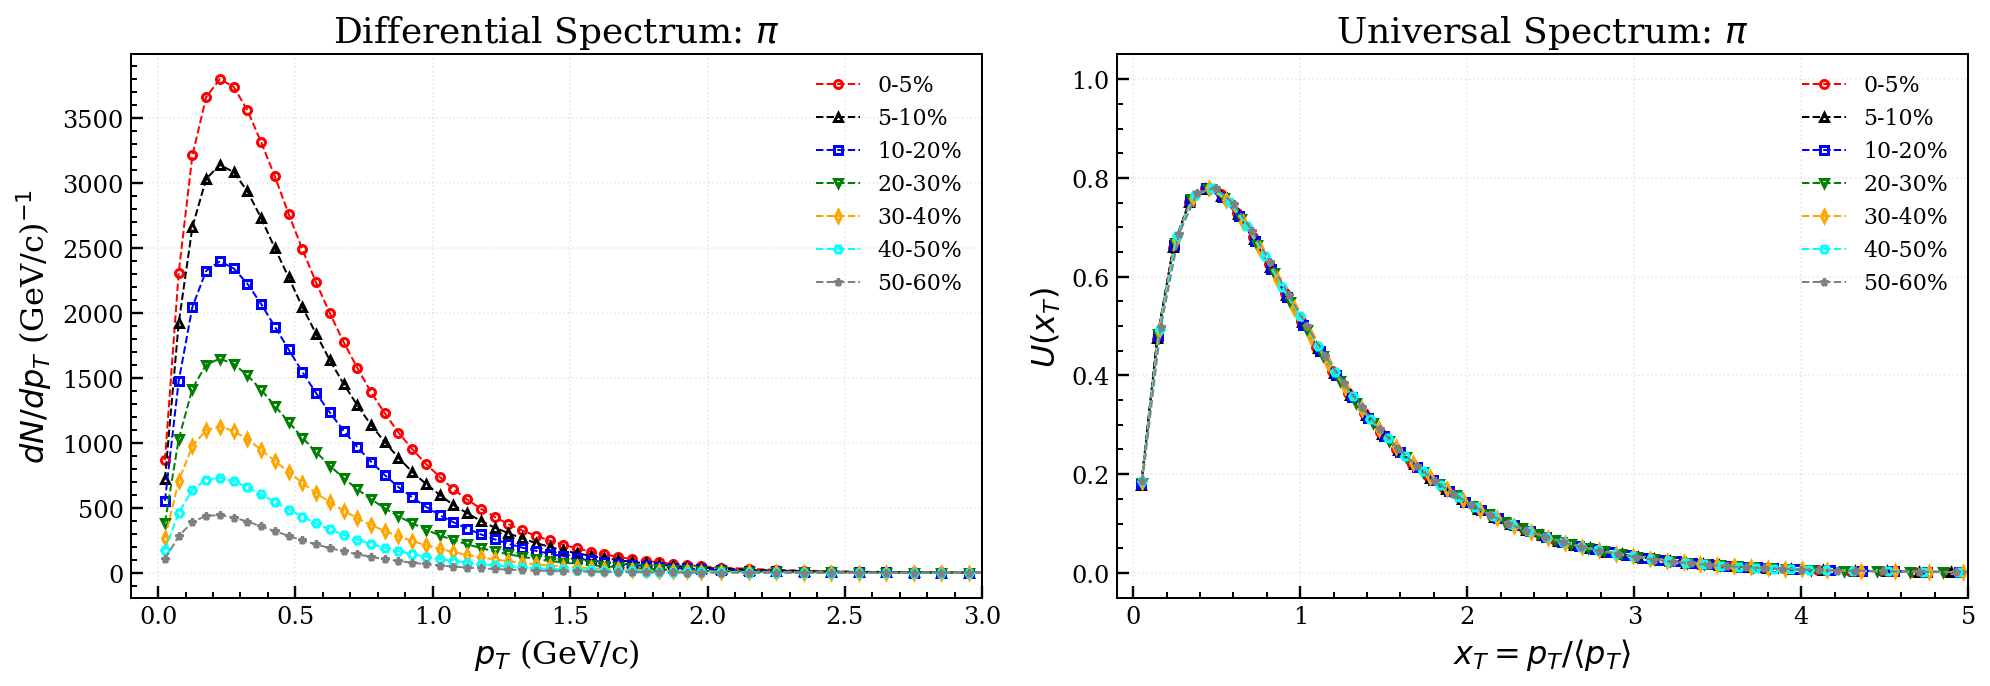

✓ Saved: output/spectra_ka.png


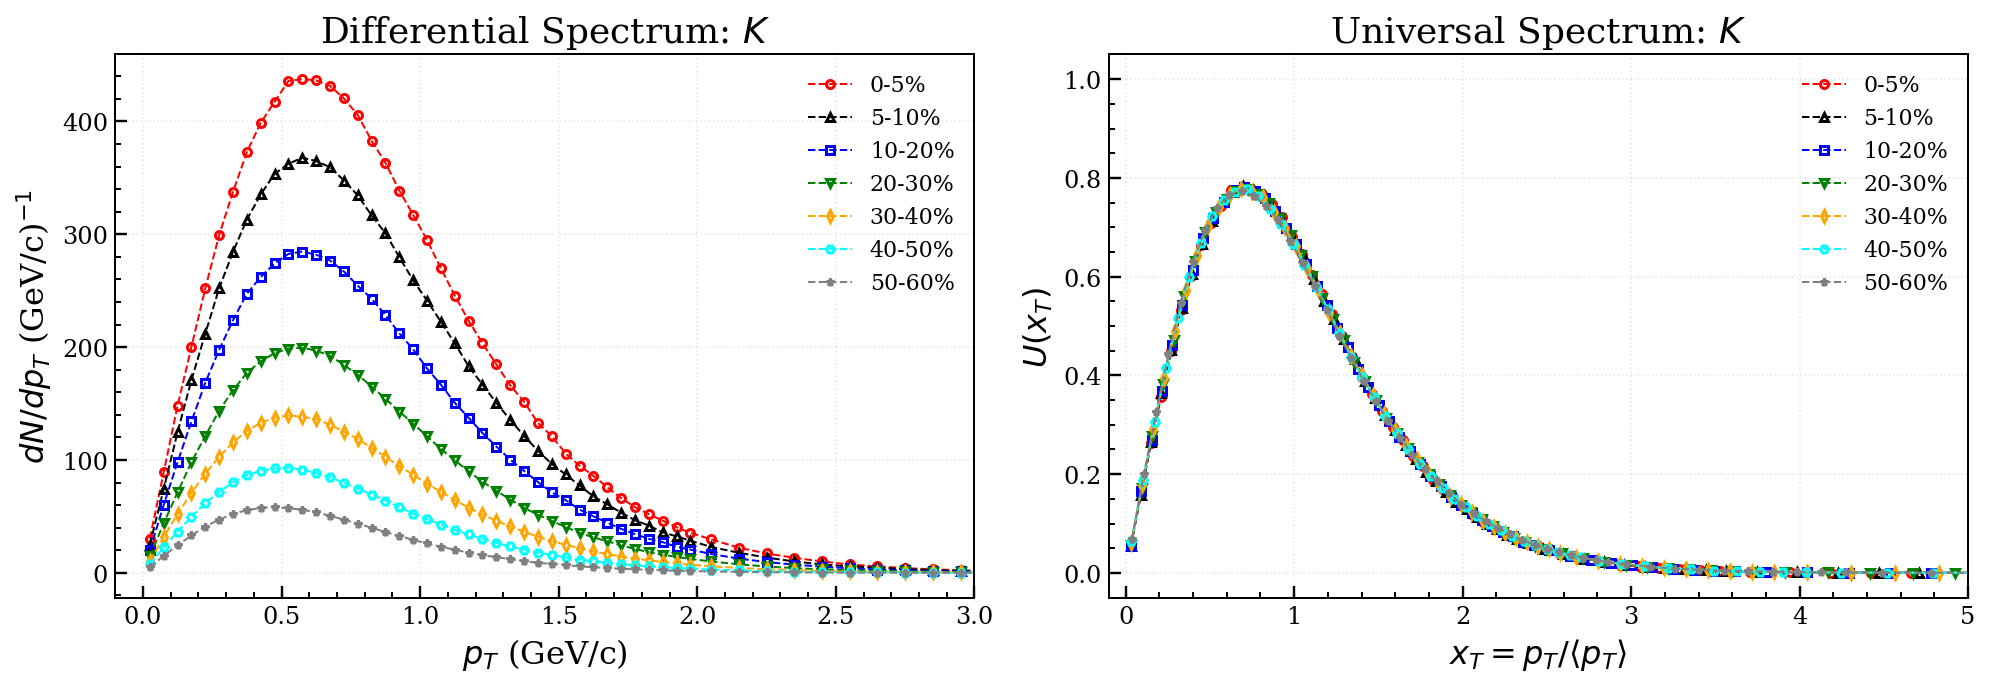

✓ Saved: output/spectra_pr.png


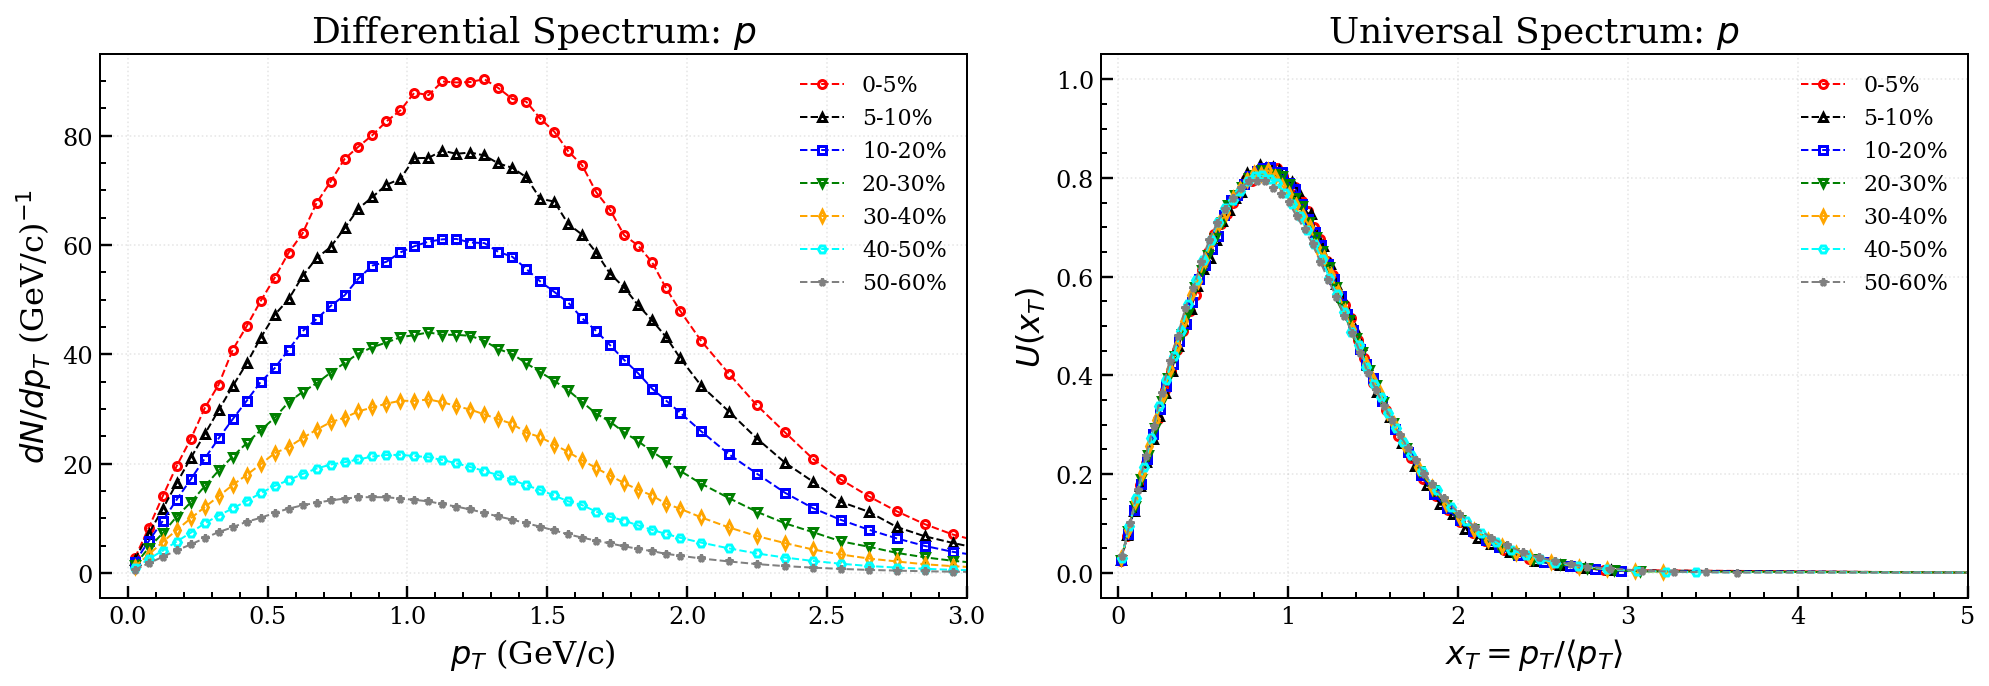

✓ Saved: output/spectra_Sigma.png


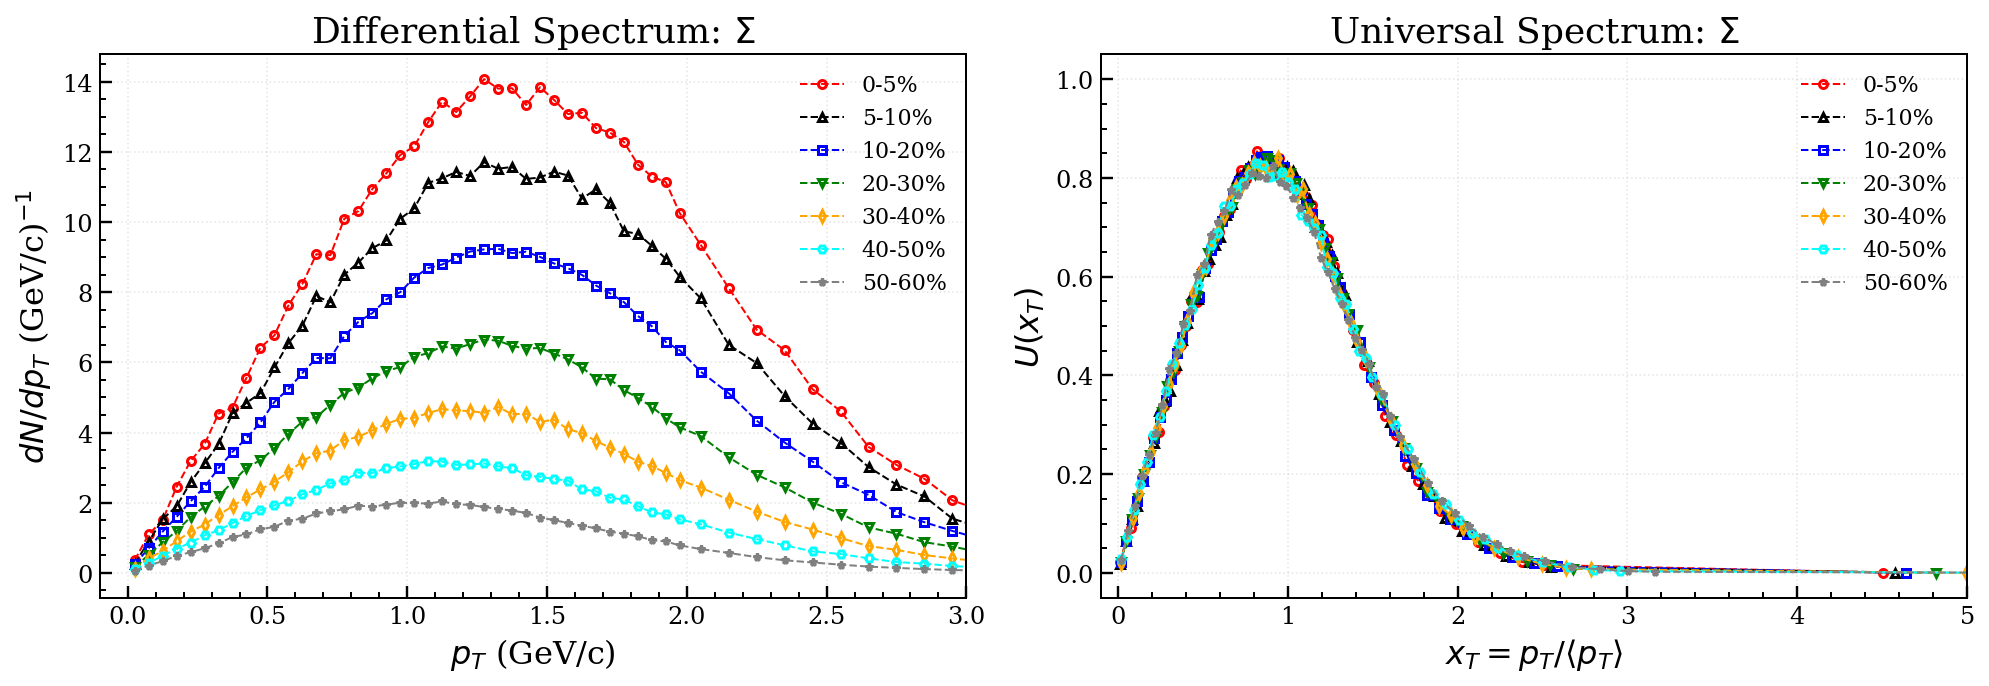

✓ Saved: output/spectra_Xi.png


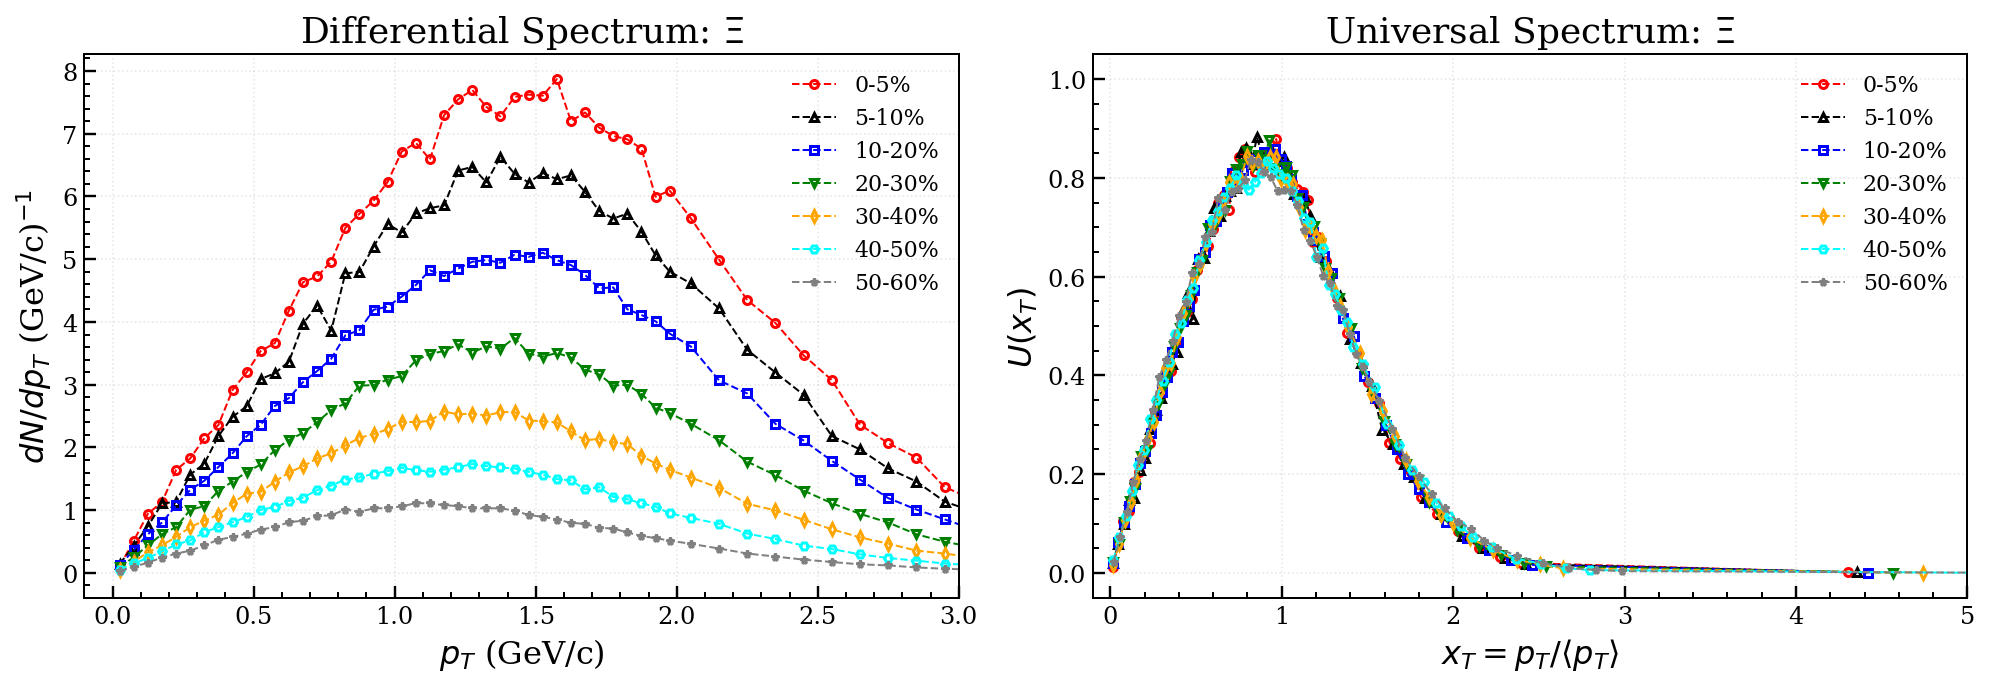

In [10]:
def plot_single_particle(particle_name, results, pt_list, 
                        centrality_labels, colors, markers, fontsize=16):
    """Create a two-panel plot for a single particle species."""
    fig, (ax_diff, ax_univ) = plt.subplots(1, 2, figsize=(14, 5))
    
    particle_label = PARTICLES[particle_name]['label']
    n_cent = len(centrality_labels)
    
    for cent_idx in range(n_cent):
        # Differential spectrum
        spectrum = results['differential_spectra'][particle_name][cent_idx]
        ax_diff.plot(pt_list, spectrum,
                    color=colors[cent_idx], linestyle='--',
                    marker=markers[cent_idx], markersize=4,
                    markerfacecolor='none', markeredgewidth=1.5,
                    label=centrality_labels[cent_idx])
        
        # Universal spectrum
        x_T = results['x_T'][particle_name][cent_idx]
        U = results['universal_spectra'][particle_name][cent_idx]
        ax_univ.plot(x_T, U,
                    color=colors[cent_idx], linestyle='--',
                    marker=markers[cent_idx], markersize=4,
                    markerfacecolor='none', markeredgewidth=1.5,
                    label=centrality_labels[cent_idx])
    
    # Configure left panel (differential)
    ax_diff.set_xlabel(r'$p_T$ (GeV/c)', fontsize=fontsize)
    ax_diff.set_ylabel(r'$dN/dp_T$ (GeV/c)$^{-1}$', fontsize=fontsize)
    ax_diff.set_xlim(-0.1, 3.0)
    ax_diff.set_title(f'Differential Spectrum: {particle_label}', fontsize=fontsize+2)
    ax_diff.legend(loc='best', frameon=False, fontsize=11)
    ax_diff.grid(alpha=0.3, linestyle=':')
    
    # Configure right panel (universal)
    ax_univ.set_xlabel(r'$x_T = p_T / \langle p_T \rangle$', fontsize=fontsize)
    ax_univ.set_ylabel(r'$U(x_T)$', fontsize=fontsize)
    ax_univ.set_xlim(-0.1, 5.0)
    ax_univ.set_ylim(-0.05, 1.05)
    ax_univ.set_title(f'Universal Spectrum: {particle_label}', fontsize=fontsize+2)
    ax_univ.legend(loc='best', frameon=False, fontsize=11)
    ax_univ.grid(alpha=0.3, linestyle=':')
    
    plt.tight_layout()
    return fig

# Create individual plots for each particle
for particle_name in PARTICLE_ORDER:
    fig = plot_single_particle(particle_name, results, PT_LIST,
                               CENTRALITY_LABELS, COLORS, MARKERS)
    
    # Save figure
    fig_file = output_dir / f'spectra_{particle_name}.png'
    fig.savefig(fig_file, dpi=300, bbox_inches='tight')
    print(f"✓ Saved: {fig_file}")
    
    plt.show()

### 11. Create Combined Multi-Panel Plot


✓ Saved combined plot: output/universal_spectra_combined.png


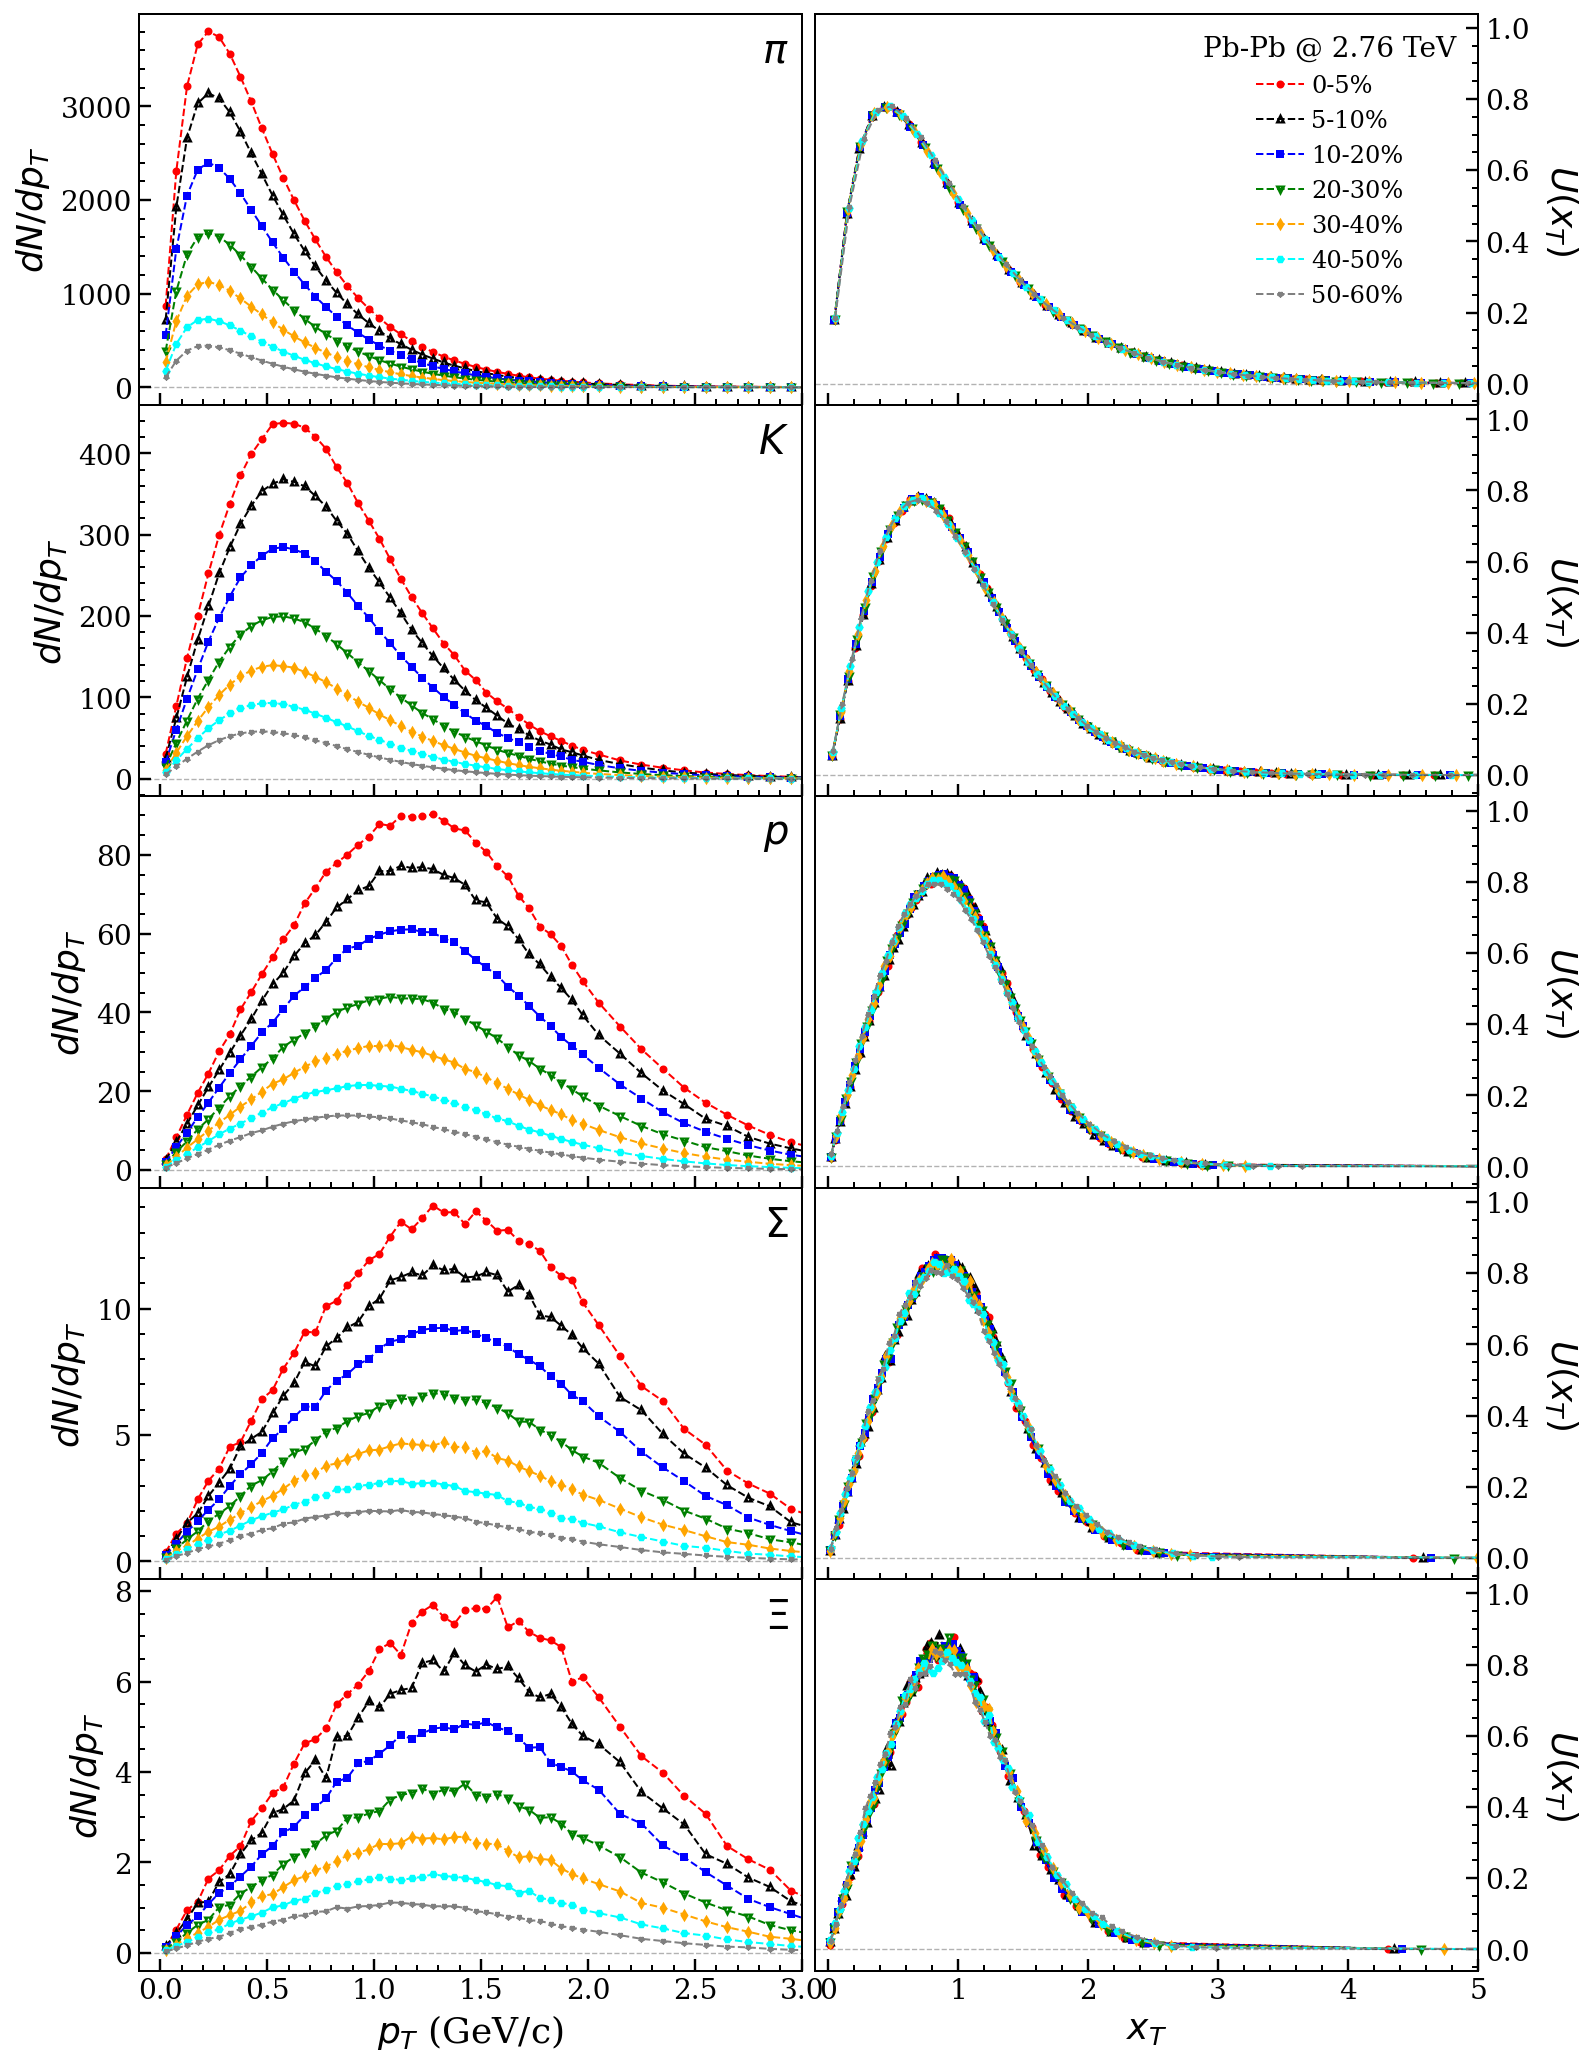

In [11]:
def plot_all_particles_combined(results, pt_list, particle_order, particles_info,
                               centrality_labels, colors, markers, fontsize=18):
    """Create the full 5x2 comparison plot."""
    n_particles = len(particle_order)
    fig, axes = plt.subplots(n_particles, 2, figsize=(12, 18), 
                             sharey=False, sharex='col')
    
    for row, particle_name in enumerate(particle_order):
        particle_label = particles_info[particle_name]['label']
        ax_diff = axes[row, 0]
        ax_univ = axes[row, 1]
        
        # Plot each centrality
        for cent_idx in range(len(centrality_labels)):
            # Differential spectrum
            spectrum = results['differential_spectra'][particle_name][cent_idx]
            ax_diff.plot(pt_list, spectrum,
                        color=colors[cent_idx], linestyle='--',
                        marker=markers[cent_idx], markersize=2,
                        markerfacecolor='none', markeredgewidth=2)
            
            # Universal spectrum
            x_T = results['x_T'][particle_name][cent_idx]
            U = results['universal_spectra'][particle_name][cent_idx]
            ax_univ.plot(x_T, U,
                        color=colors[cent_idx], linestyle='--',
                        marker=markers[cent_idx], markersize=2,
                        markerfacecolor='none', markeredgewidth=2,
                        label=centrality_labels[cent_idx])
        
        # Configure axes
        ax_diff.set_xlim(-0.1, 3.0)
        ax_univ.set_xlim(-0.1, 5.0)
        ax_univ.set_ylim(-0.06, 1.04)
        
        # Legends (top row only)
        if row == 0:
            ax_univ.legend(loc='best', frameon=False, fontsize=12,
                          title='Pb-Pb @ 2.76 TeV', title_fontsize=14,
                          handletextpad=0.3, numpoints=1)
        
        # Labels
        if row == n_particles - 1:
            ax_diff.set_xlabel(r'$p_T$ (GeV/c)', fontsize=fontsize)
            ax_univ.set_xlabel(r'$x_T$', fontsize=fontsize)
        
        ax_diff.set_ylabel(r'$dN/dp_T$', fontsize=fontsize)
        ax_univ.yaxis.set_label_position("right")
        ax_univ.yaxis.tick_right()
        ax_univ.set_ylabel(r'$U(x_T)$', rotation=-90, fontsize=fontsize, labelpad=25)
        
        # Reference lines
        ax_diff.axhline(y=0, color='black', linestyle='--', linewidth=0.7, alpha=0.3)
        ax_univ.axhline(y=0, color='black', linestyle='--', linewidth=0.7, alpha=0.3)
        
        # Particle label
        ax_diff.text(0.98, 0.95, particle_label, fontsize=fontsize+2,
                    transform=ax_diff.transAxes, va='top', ha='right')
        
        # Tick parameters
        ax_diff.tick_params(labelsize=14)
        ax_univ.tick_params(labelsize=14)
    
    plt.subplots_adjust(wspace=0.02, hspace=0)
    return fig

# Create combined plot
fig_combined = plot_all_particles_combined(results, PT_LIST, PARTICLE_ORDER, 
                                           PARTICLES, CENTRALITY_LABELS, 
                                           COLORS, MARKERS)

# Save combined figure
combined_file = output_dir / 'universal_spectra_combined.png'
fig_combined.savefig(combined_file, dpi=300, bbox_inches='tight')
print(f"\n✓ Saved combined plot: {combined_file}")

plt.show()

### 12. Summary Statistics

In [12]:
print("\n" + "="*70)
print("SUMMARY STATISTICS")
print("="*70)

for particle_name in PARTICLE_ORDER:
    print(f"\n{PARTICLES[particle_name]['name'].upper()} ({PARTICLES[particle_name]['label']})")
    print("-" * 70)
    print(f"{'Centrality':<15} {'<pT> (GeV/c)':<15} {'N (mult.)':<15} {'U_max':<15}")
    print("-" * 70)
    
    for cent_idx, cent_label in enumerate(CENTRALITY_LABELS):
        mean_pt = results['mean_pt'][particle_name][cent_idx]
        mult = results['multiplicity'][particle_name][cent_idx]
        u_max = np.max(results['universal_spectra'][particle_name][cent_idx])
        print(f"{cent_label:<15} {mean_pt:<15.4f} {mult:<15.2f} {u_max:<15.4f}")

print("\n" + "="*70)
print("✓ Analysis complete!")
print("="*70)


SUMMARY STATISTICS

PION ($\pi$)
----------------------------------------------------------------------
Centrality      <pT> (GeV/c)    N (mult.)       U_max          
----------------------------------------------------------------------
0-5%            0.5241          2558.91         0.7785         
5-10%           0.5207          2102.38         0.7781         
10-20%          0.5156          1588.91         0.7786         
20-30%          0.5052          1071.43         0.7771         
30-40%          0.4932          713.53          0.7789         
40-50%          0.4758          447.06          0.7795         
50-60%          0.4568          260.54          0.7801         

KAON ($K$)
----------------------------------------------------------------------
Centrality      <pT> (GeV/c)    N (mult.)       U_max          
----------------------------------------------------------------------
0-5%            0.8366          470.28          0.7782         
5-10%           0.8279        

### 13. Example: Load and Use Saved Data

In [13]:
# Example of how to load and use the saved data in a new session
print("Example: Loading saved data...")

loaded_data = np.load('output/universal_spectra_results.npz', allow_pickle=True)

# Access metadata
print(f"\nMetadata:")
print(f"  Date: {loaded_data['metadata/date']}")
print(f"  Events: {loaded_data['metadata/n_events']}")
print(f"  System: {loaded_data['metadata/collision_system']}")

# Access configuration
pt_bins = loaded_data['config/pt_list']
centrality_bins = loaded_data['config/centrality_bins']

print(f"\nConfiguration:")
print(f"  pT bins: {len(pt_bins)} from {pt_bins[0]:.2f} to {pt_bins[-1]:.2f} GeV/c")
print(f"  Centrality bins: {len(centrality_bins)}")

# Access specific particle data
particle = 'pi'
pi_mean_pt = loaded_data[f'particle/{particle}/mean_pt']
pi_spectrum = loaded_data[f'particle/{particle}/differential_spectra']

print(f"\nPion data:")
print(f"  Mean pT shape: {pi_mean_pt.shape}")
print(f"  Spectrum shape: {pi_spectrum.shape}")
print(f"  Mean pT values: {pi_mean_pt}")

print("\n✓ Data successfully loaded and accessed!")

Example: Loading saved data...

Metadata:
  Date: 2025-12-14 22:57:34
  Events: 5040
  System: Pb-Pb @ 2.76 TeV

Configuration:
  pT bins: 56 from 0.03 to 7.00 GeV/c
  Centrality bins: 7

Pion data:
  Mean pT shape: (7,)
  Spectrum shape: (7, 56)
  Mean pT values: [0.52410159 0.52071689 0.51560158 0.50516576 0.49315652 0.47580004
 0.45675872]

✓ Data successfully loaded and accessed!


### 13. Transverse Mass (mT) Spectra Analysis

Now we compute the mT-spectra using the Jacobian transformation: 
- $m_T = \sqrt{p_T^2 + m_0^2}$
- $\frac{dN}{dm_T} = \frac{p_T}{m_T} \cdot \frac{dN}{dp_T}$
- Universal scaling: $U(m_T) = \frac{\langle m_T - m_0 \rangle}{N} \cdot \frac{dN}{d(m_T - m_0)}$


In [14]:
def compute_mT_spectrum(dNdpt, mass, pt_bins):
    """
    Convert dN/dpT to dN/dmT using Jacobian transformation.
    
    Parameters
    ----------
    dNdpt : np.ndarray
        Differential spectrum dN/dpT
    mass : float
        Rest mass of particle (GeV/c²)
    pt_bins : np.ndarray
        pT bin centers (GeV/c)
        
    Returns
    -------
    mT_minus_m0 : np.ndarray
        mT - m0 values (GeV/c²)
    dNdmT : np.ndarray
        Differential spectrum dN/dmT
    """
    # Transverse mass: mT = sqrt(pT² + m0²)
    mT = np.sqrt(pt_bins**2 + mass**2)
    
    # Jacobian: dN/dmT = (pT/mT) * dN/dpT
    dNdmT = (pt_bins / mT) * dNdpt
    
    # mT - m0 for plotting
    mT_minus_m0 = mT - mass
    
    return mT_minus_m0, dNdmT


def compute_universal_mT_spectra(dNdmT_cent, mT_minus_m0, mass):
    """
    Compute universal scaling function for mT spectra.
    
    Following: U(mT) = <mT - m0> / N * dN/d(mT - m0)
    where x_scaled = (mT - m0) / <mT - m0>
    
    Parameters
    ----------
    dNdmT_cent : np.ndarray, shape (n_events, n_bins)
        dN/dmT spectra for events in this centrality
    mT_minus_m0 : np.ndarray
        mT - m0 values (GeV/c²)
    mass : float
        Rest mass (not used in calculation but kept for consistency)
        
    Returns
    -------
    mean_mT_minus_m0 : float
        Mean <mT - m0> (GeV/c²)
    N : float
        Total multiplicity
    U_mT : np.ndarray
        Universal function U(mT)
    mean_spectrum : np.ndarray
        Average dN/d(mT-m0) spectrum
    """
    # Average spectrum over events
    mean_spectrum = np.mean(dNdmT_cent, axis=0)
    
    # Total multiplicity
    N = np.trapz(mean_spectrum, mT_minus_m0)
    
    # Mean <mT - m0>
    mean_mT_minus_m0 = np.trapz(mT_minus_m0 * mean_spectrum, mT_minus_m0) / N
    
    # Universal function
    U_mT = mean_mT_minus_m0 * mean_spectrum / N
    
    return mean_mT_minus_m0, N, U_mT, mean_spectrum

print("mT spectrum functions defined ✓")

mT spectrum functions defined ✓


### 14. Compute mT Spectra for All Particles

In [15]:
print("Computing mT spectra for all particles and centralities...")

# Initialize storage for mT results
mT_results = {
    'mT_minus_m0': {},           # mT - m0 values
    'differential_mT_spectra': {},  # dN/d(mT-m0)
    'universal_mT_spectra': {},     # U(mT)
    'mean_mT_minus_m0': {},         # <mT - m0>
    'multiplicity_mT': {},          # N from mT integration
    'x_mT_scaled': {}               # (mT - m0) / <mT - m0>
}

for particle_name in PARTICLE_ORDER:
    pid = PARTICLES[particle_name]['id']
    mass = MASS_LIST[pid]
    dNdpt = Qn_norm_all[:, pid, :]
    
    # Initialize arrays
    n_cent = len(cent_groups)
    n_pt = len(PT_LIST)
    
    mT_results['differential_mT_spectra'][particle_name] = np.zeros((n_cent, n_pt))
    mT_results['universal_mT_spectra'][particle_name] = np.zeros((n_cent, n_pt))
    mT_results['mean_mT_minus_m0'][particle_name] = np.zeros(n_cent)
    mT_results['multiplicity_mT'][particle_name] = np.zeros(n_cent)
    mT_results['x_mT_scaled'][particle_name] = np.zeros((n_cent, n_pt))
    
    # Compute mT - m0 (same for all events)
    mT_minus_m0_ref, _ = compute_mT_spectrum(dNdpt[0], mass, PT_LIST)
    mT_results['mT_minus_m0'][particle_name] = mT_minus_m0_ref
    
    # Process each centrality
    for cent_idx, event_indices in enumerate(cent_groups):
        if len(event_indices) == 0:
            continue
        
        # Convert all events to mT spectra
        dNdmT_events = []
        for evt_idx in event_indices:
            _, dNdmT = compute_mT_spectrum(dNdpt[evt_idx], mass, PT_LIST)
            dNdmT_events.append(dNdmT)
        
        dNdmT_events = np.array(dNdmT_events)
        
        # Compute universal mT spectra
        mean_mT_m0, N_mT, U_mT, mean_mT_spectrum = compute_universal_mT_spectra(
            dNdmT_events, mT_minus_m0_ref, mass
        )
        
        # Store results
        mT_results['differential_mT_spectra'][particle_name][cent_idx] = mean_mT_spectrum
        mT_results['universal_mT_spectra'][particle_name][cent_idx] = U_mT
        mT_results['mean_mT_minus_m0'][particle_name][cent_idx] = mean_mT_m0
        mT_results['multiplicity_mT'][particle_name][cent_idx] = N_mT
        mT_results['x_mT_scaled'][particle_name][cent_idx] = mT_minus_m0_ref / mean_mT_m0
    
    print(f"  ✓ {PARTICLES[particle_name]['name']}")

print("✓ All mT spectra computed")

Computing mT spectra for all particles and centralities...
  ✓ pion
  ✓ kaon
  ✓ proton
  ✓ Sigma
  ✓ Xi
✓ All mT spectra computed


### 15. Plot mT Spectra for Individual Particles

✓ Saved: output/mT_spectra_pi.png


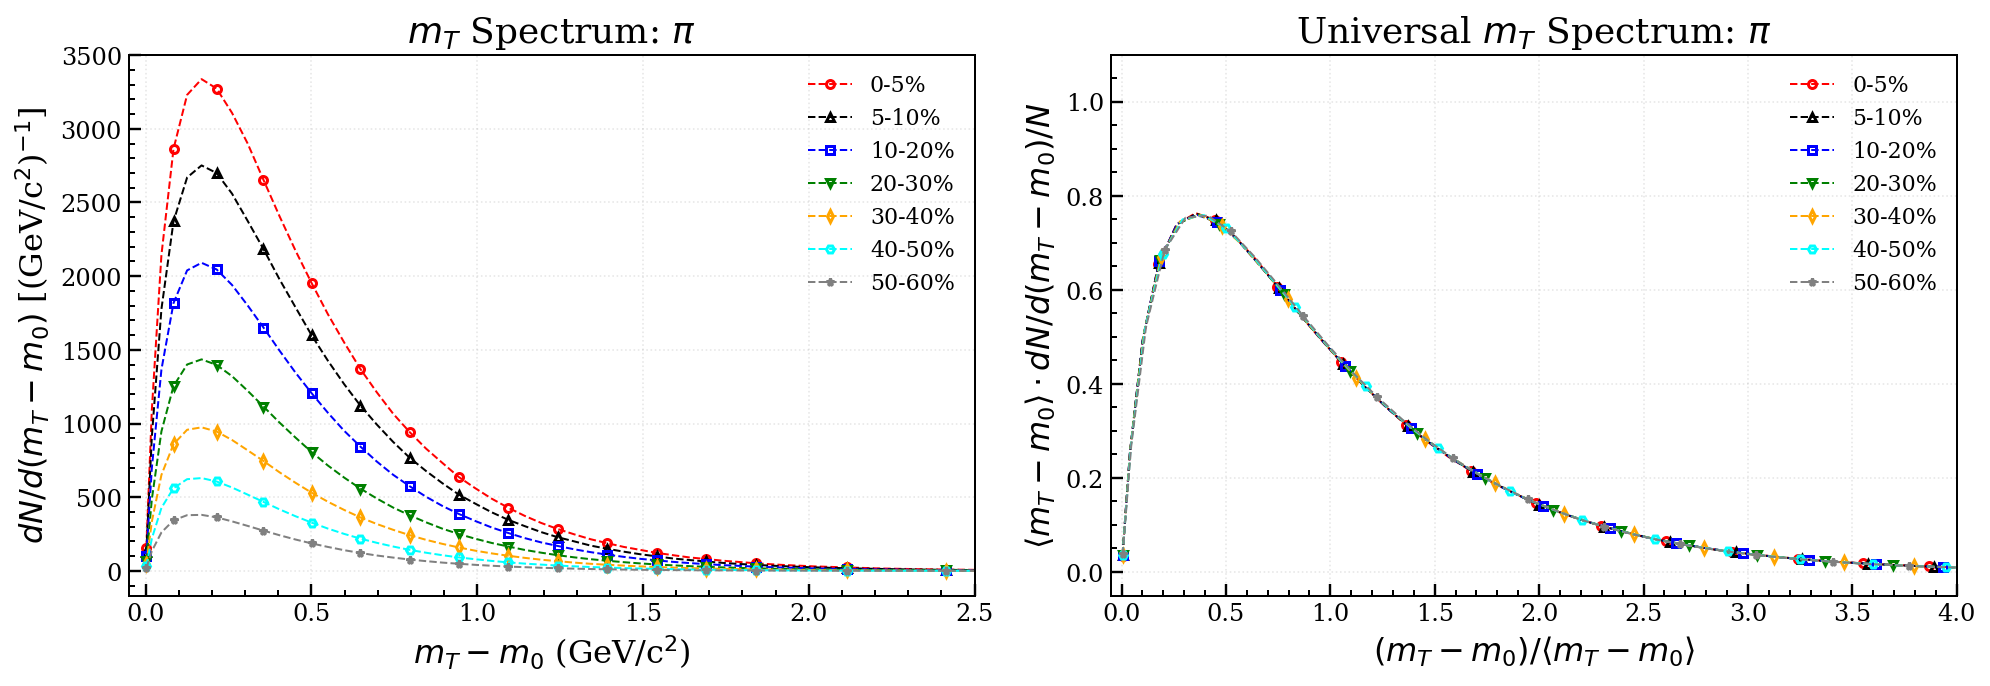

✓ Saved: output/mT_spectra_ka.png


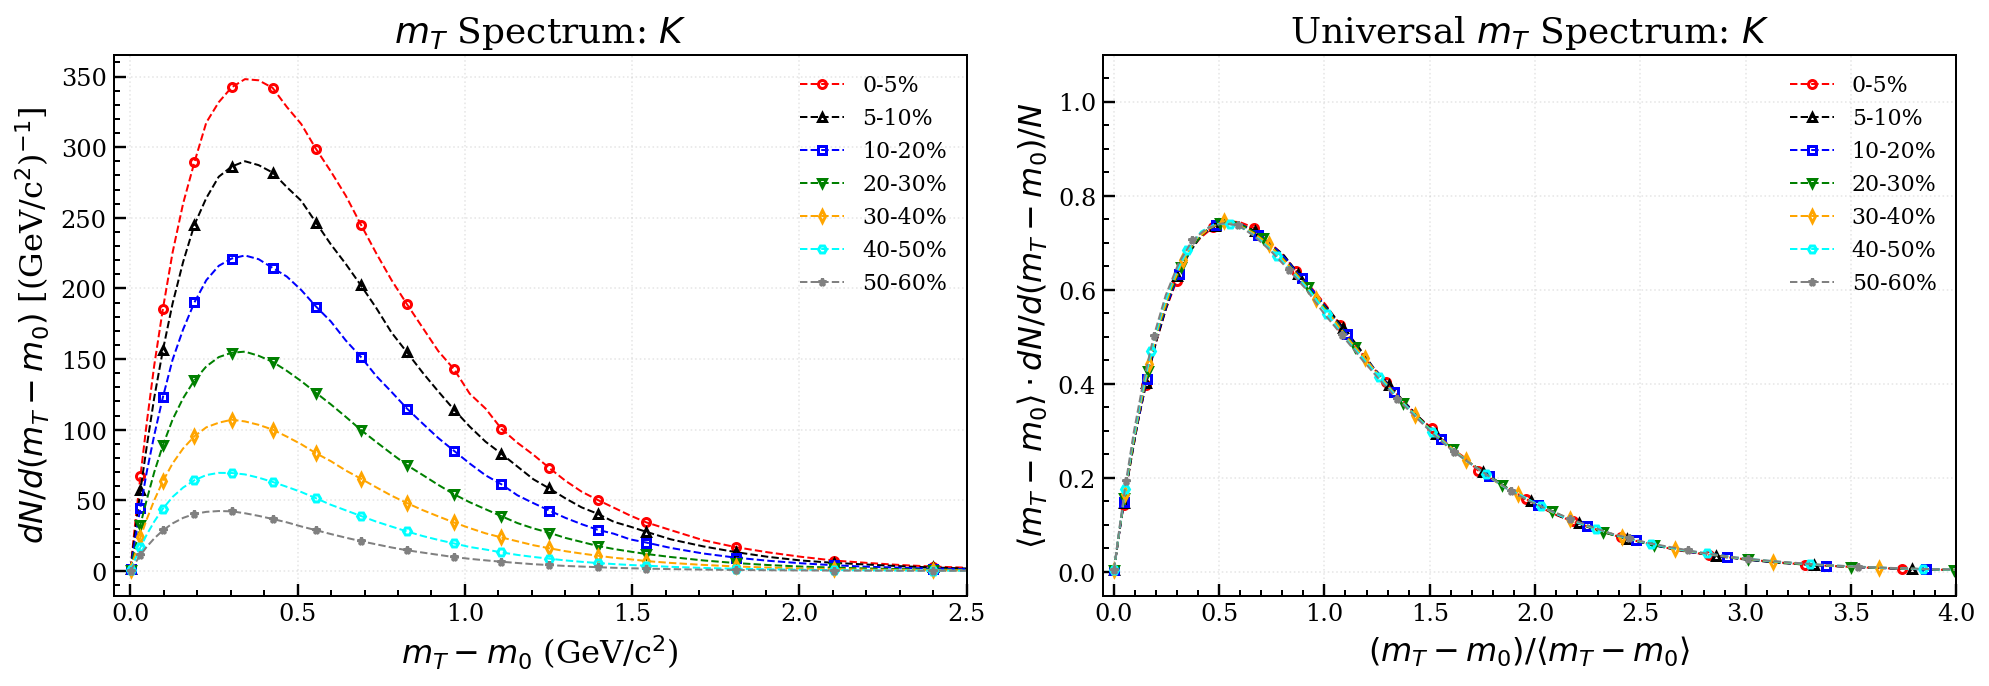

✓ Saved: output/mT_spectra_pr.png


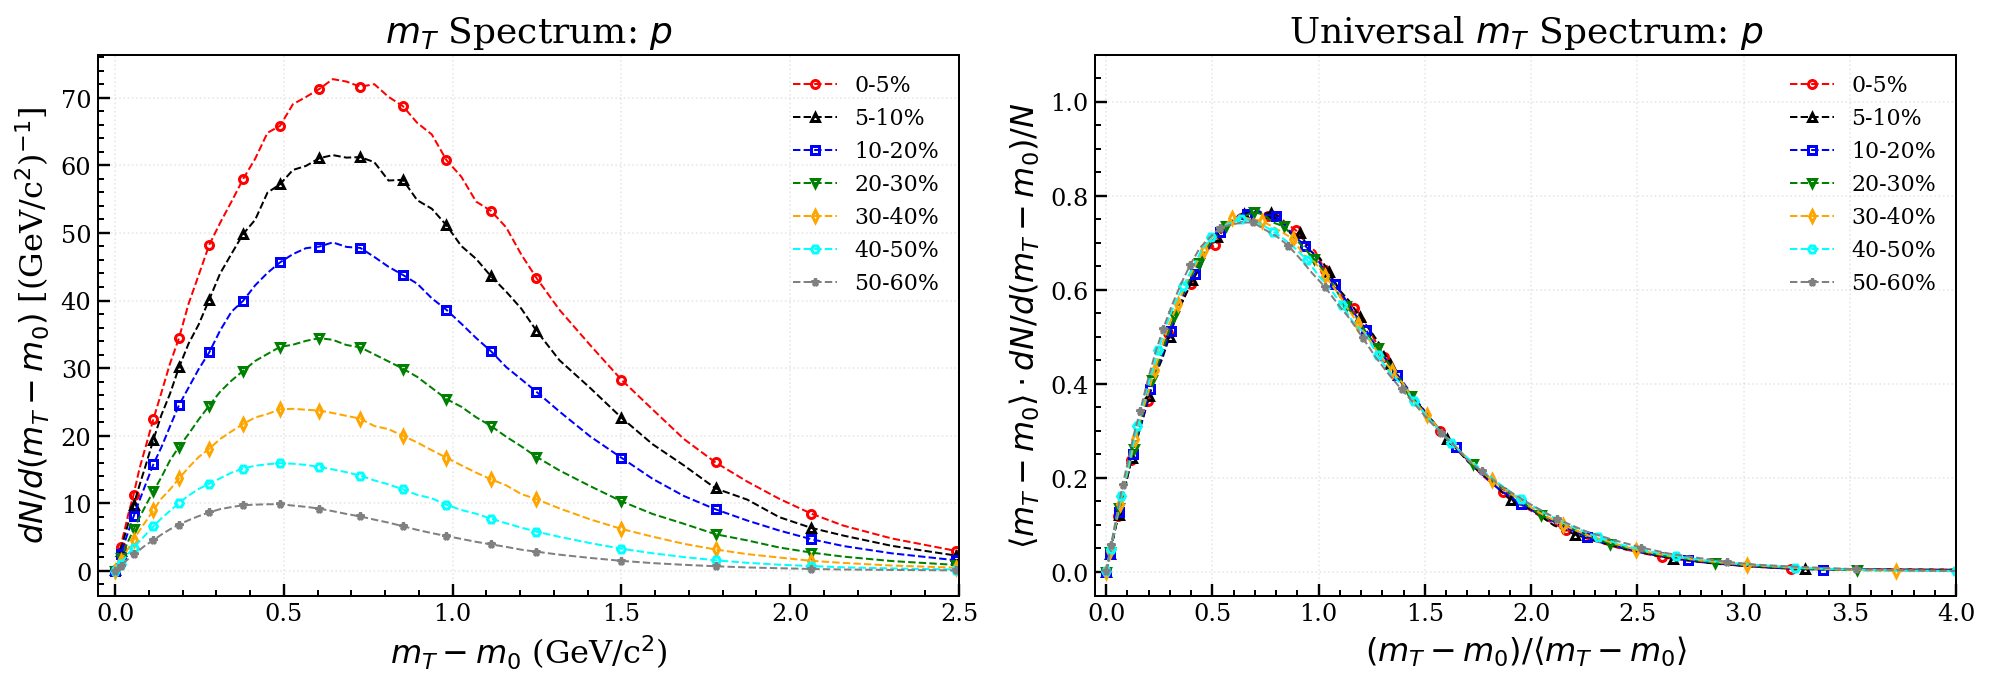

✓ Saved: output/mT_spectra_Sigma.png


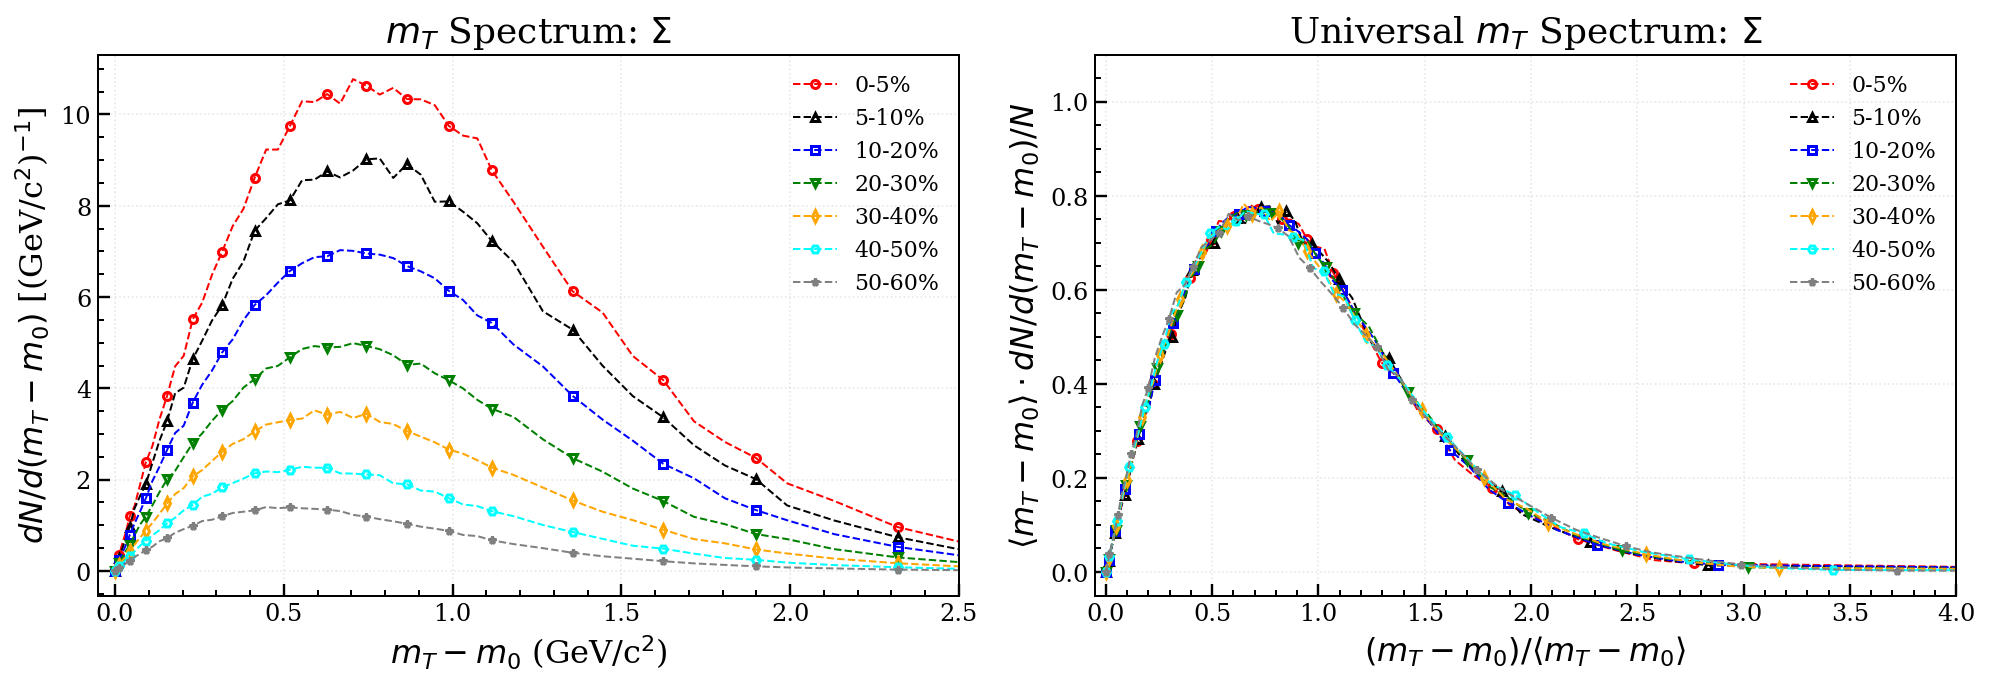

✓ Saved: output/mT_spectra_Xi.png


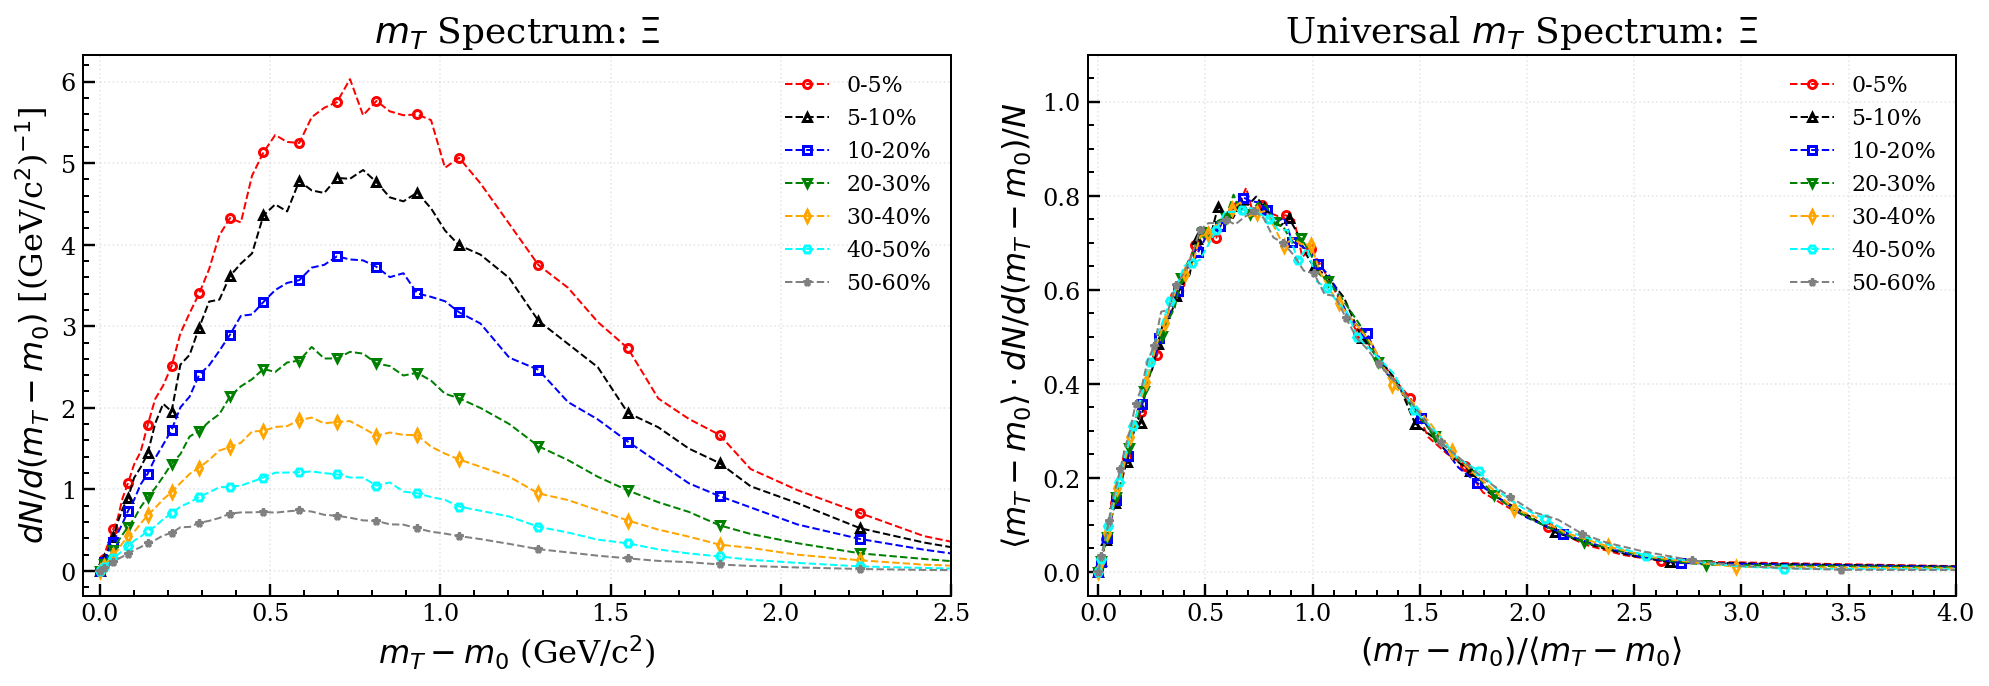

In [18]:
def plot_single_particle_mT(particle_name, mT_results, centrality_labels, 
                            colors, markers, fontsize=16):
    """Create two-panel plot for mT spectra of a single particle."""
    fig, (ax_diff, ax_univ) = plt.subplots(1, 2, figsize=(14, 5))
    
    particle_label = PARTICLES[particle_name]['label']
    n_cent = len(centrality_labels)
    mT_minus_m0 = mT_results['mT_minus_m0'][particle_name]
    
    for cent_idx in range(n_cent):
        # Differential mT spectrum
        spectrum_mT = mT_results['differential_mT_spectra'][particle_name][cent_idx]
        ax_diff.plot(mT_minus_m0, spectrum_mT,
                    color=colors[cent_idx], linestyle='--',
                    marker=markers[cent_idx], markersize=4,
                    markerfacecolor='none', markeredgewidth=1.5,
                    markevery=3, label=centrality_labels[cent_idx])
        
        # Universal mT spectrum
        x_mT = mT_results['x_mT_scaled'][particle_name][cent_idx]
        U_mT = mT_results['universal_mT_spectra'][particle_name][cent_idx]
        ax_univ.plot(x_mT, U_mT,
                    color=colors[cent_idx], linestyle='--',
                    marker=markers[cent_idx], markersize=4,
                    markerfacecolor='none', markeredgewidth=1.5,
                    markevery=3, label=centrality_labels[cent_idx])
    
    # Configure left panel
    ax_diff.set_xlabel(r'$m_T - m_0$ (GeV/c$^2$)', fontsize=fontsize)
    ax_diff.set_ylabel(r'$dN/d(m_T - m_0)$ [(GeV/c$^2$)$^{-1}$]', fontsize=fontsize)
    ax_diff.set_xlim(-0.05, 2.5)
    ax_diff.set_title(f'$m_T$ Spectrum: {particle_label}', fontsize=fontsize+2)
    ax_diff.legend(loc='best', frameon=False, fontsize=11)
    ax_diff.grid(alpha=0.3, linestyle=':')
    
    # Configure right panel
    ax_univ.set_xlabel(r'$(m_T - m_0) / \langle m_T - m_0 \rangle$'
, fontsize=fontsize)
    ax_univ.set_ylabel(r'$\langle m_T - m_0 \rangle \cdot dN/d(m_T-m_0) / N$'
, fontsize=fontsize)
    ax_univ.set_xlim(-0.05, 4.0)
    ax_univ.set_ylim(-0.05, 1.1)
    ax_univ.set_title(f'Universal $m_T$ Spectrum: {particle_label}', fontsize=fontsize+2)
    ax_univ.legend(loc='best', frameon=False, fontsize=11)
    ax_univ.grid(alpha=0.3, linestyle=':')
    
    plt.tight_layout()
    return fig

# Create and save mT plots for each particle
for particle_name in PARTICLE_ORDER:
    fig = plot_single_particle_mT(particle_name, mT_results, CENTRALITY_LABELS,
                                   COLORS, MARKERS)
    
    fig_file = output_dir / f'mT_spectra_{particle_name}.png'
    fig.savefig(fig_file, dpi=300, bbox_inches='tight')
    print(f"✓ Saved: {fig_file}")
    
    plt.show()

### 16. Combined mT Spectra Plot (All Particles, One Centrality)


✓ Saved: output/mT_spectra_all_particles.png


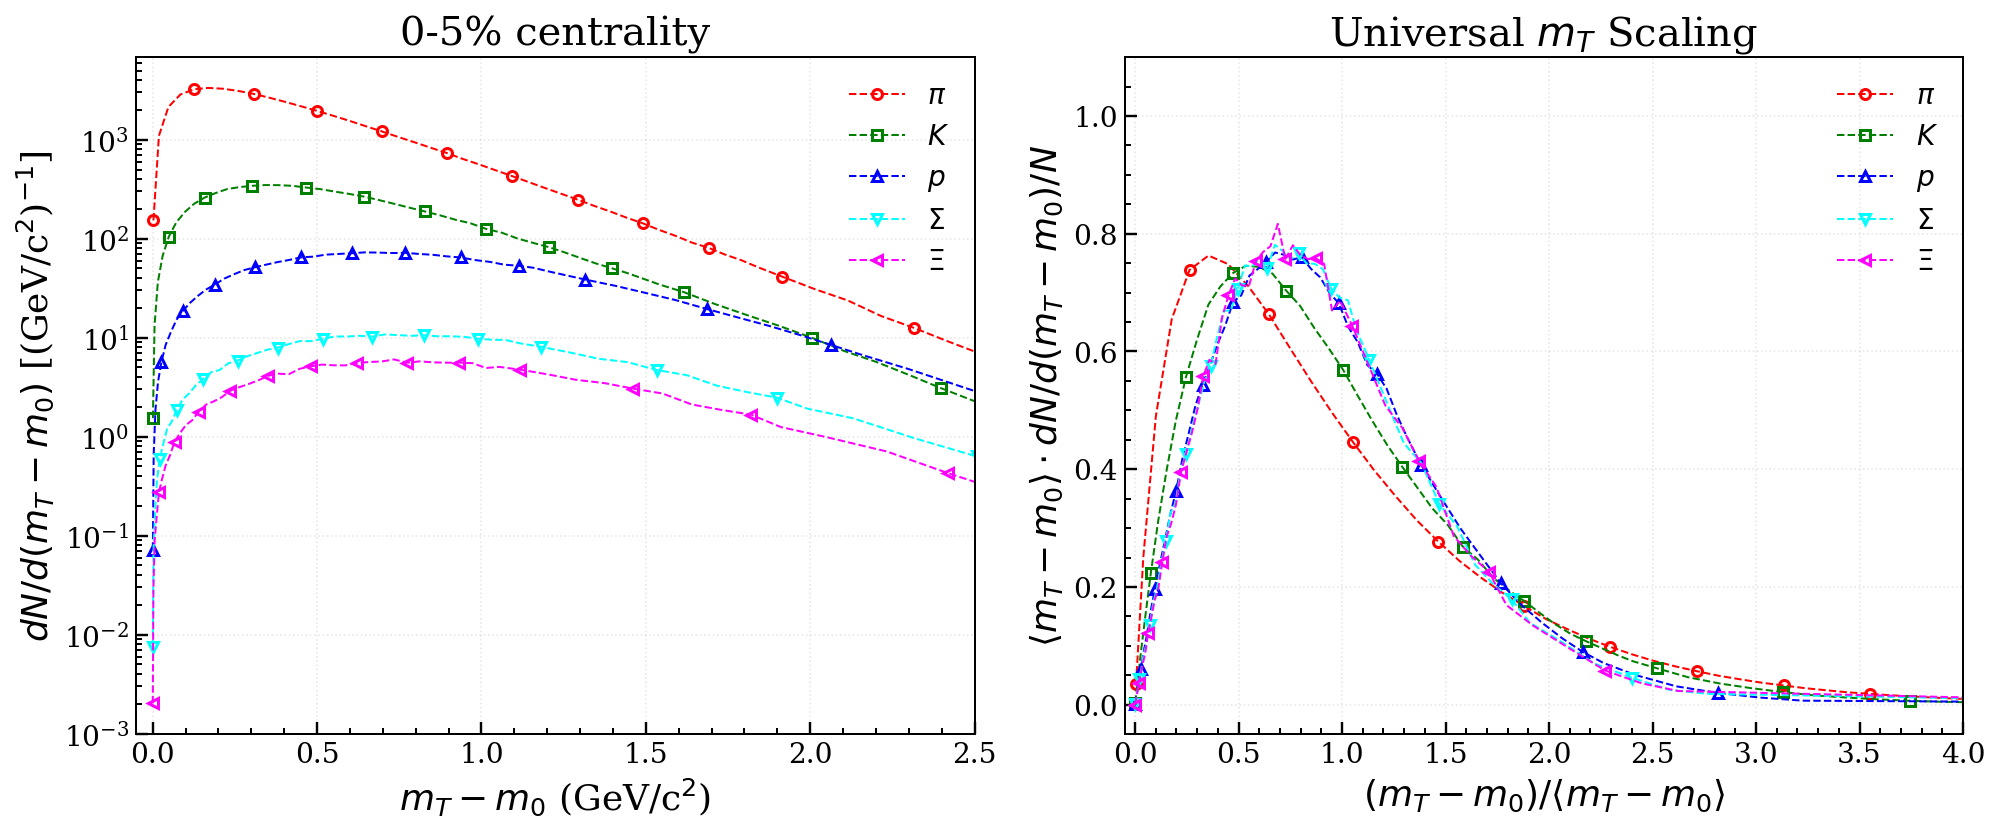

In [20]:
# Choose most central bin (0-5%)
cent_idx = 0
cent_label = CENTRALITY_LABELS[cent_idx]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

particle_colors_mT = {
    'pi': 'red', 'ka': 'green', 'pr': 'blue', 
    'Sigma': 'cyan', 'Xi': 'magenta'
}
particle_markers_mT = {
    'pi': 'o', 'ka': 's', 'pr': '^', 
    'Sigma': 'v', 'Xi': '<'
}

for particle_name in PARTICLE_ORDER:
    mT_minus_m0 = mT_results['mT_minus_m0'][particle_name]
    spectrum_mT = mT_results['differential_mT_spectra'][particle_name][cent_idx]
    x_mT = mT_results['x_mT_scaled'][particle_name][cent_idx]
    U_mT = mT_results['universal_mT_spectra'][particle_name][cent_idx]
    
    particle_label = PARTICLES[particle_name]['label']
    color = particle_colors_mT[particle_name]
    marker = particle_markers_mT[particle_name]
    
    # Differential mT spectrum (log scale)
    ax1.plot(mT_minus_m0, spectrum_mT,
            color=color, marker=marker, linestyle='--',
            markersize=5, markerfacecolor='none', markeredgewidth=1.5,
            label=particle_label, markevery=4)
    
    # Universal mT spectrum
    ax2.plot(x_mT, U_mT,
            color=color, marker=marker, linestyle='--',
            markersize=5, markerfacecolor='none', markeredgewidth=1.5,
            label=particle_label, markevery=4)

# Configure axes
ax1.set_xlabel(r'$m_T - m_0$ (GeV/c$^2$)', fontsize=18)
ax1.set_ylabel(r'$dN/d(m_T - m_0)$ [(GeV/c$^2$)$^{-1}$]', fontsize=18)
ax1.set_xlim(-0.05, 2.5)
ax1.set_yscale('log')
ax1.set_title(f'{cent_label} centrality', fontsize=20)
ax1.legend(loc='best', frameon=False, fontsize=14)
ax1.grid(True, alpha=0.3, linestyle=':')
ax1.tick_params(labelsize=14)

ax2.set_xlabel(r'$(m_T - m_0) / \langle m_T - m_0 \rangle$'
, fontsize=18)
ax2.set_ylabel(r'$\langle m_T - m_0 \rangle \cdot dN/d(m_T-m_0) / N$'
, fontsize=18)
ax2.set_xlim(-0.05, 4.0)
ax2.set_ylim(-0.05, 1.1)
ax2.set_title('Universal $m_T$ Scaling', fontsize=20)
ax2.legend(loc='upper right', frameon=False, fontsize=14)
ax2.grid(True, alpha=0.3, linestyle=':')
ax2.tick_params(labelsize=14)

plt.tight_layout()
combined_mT_file = output_dir / 'mT_spectra_all_particles.png'
fig.savefig(combined_mT_file, dpi=300, bbox_inches='tight')
print(f"\n✓ Saved: {combined_mT_file}")
plt.show()

### 17. Save mT Results to NPZ File

In [21]:
# Add mT results to save dictionary
save_dict_mT = {
    # Previous pT results metadata
    'metadata/date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'metadata/n_events': len(data),
    'metadata/delta_f_index': DELTA_F_INDEX,
    'metadata/collision_system': 'Pb-Pb @ 2.76 TeV',
    'metadata/model': 'JETSCAPE MAP Chapman-Enskog',
    
    # Configuration
    'config/pt_cuts': PT_CUTS,
    'config/pt_list': PT_LIST,
    'config/centrality_bins': np.array(CENTRALITY_BINS),
    'config/centrality_labels': np.array(CENTRALITY_LABELS),
    'config/particle_order': np.array(PARTICLE_ORDER),
    'config/mass_list': MASS_LIST,
}

# Add both pT and mT data for each particle
for particle_name in PARTICLE_ORDER:
    prefix = f'particle/{particle_name}'
    
    # pT data
    save_dict_mT[f'{prefix}/pt/differential_spectra'] = results['differential_spectra'][particle_name]
    save_dict_mT[f'{prefix}/pt/universal_spectra'] = results['universal_spectra'][particle_name]
    save_dict_mT[f'{prefix}/pt/mean_pt'] = results['mean_pt'][particle_name]
    save_dict_mT[f'{prefix}/pt/multiplicity'] = results['multiplicity'][particle_name]
    save_dict_mT[f'{prefix}/pt/x_T'] = results['x_T'][particle_name]
    
    # mT data
    save_dict_mT[f'{prefix}/mT/mT_minus_m0'] = mT_results['mT_minus_m0'][particle_name]
    save_dict_mT[f'{prefix}/mT/differential_spectra'] = mT_results['differential_mT_spectra'][particle_name]
    save_dict_mT[f'{prefix}/mT/universal_spectra'] = mT_results['universal_mT_spectra'][particle_name]
    save_dict_mT[f'{prefix}/mT/mean_mT_minus_m0'] = mT_results['mean_mT_minus_m0'][particle_name]
    save_dict_mT[f'{prefix}/mT/multiplicity'] = mT_results['multiplicity_mT'][particle_name]
    save_dict_mT[f'{prefix}/mT/x_mT_scaled'] = mT_results['x_mT_scaled'][particle_name]
    
    # Particle info
    save_dict_mT[f'{prefix}/label'] = PARTICLES[particle_name]['label']
    save_dict_mT[f'{prefix}/full_name'] = PARTICLES[particle_name]['name']

# Save complete results
complete_output_file = output_dir / 'complete_spectra_results.npz'
np.savez_compressed(complete_output_file, **save_dict_mT)

print(f"✓ Complete results (pT + mT) saved to: {complete_output_file}")
print(f"  File size: {complete_output_file.stat().st_size / 1024:.2f} KB")

✓ Complete results (pT + mT) saved to: output/complete_spectra_results.npz
  File size: 107.18 KB


### 18. Universality Test: Compare Central vs Peripheral

To demonstrate that $m_T$ scaling is more universal than $p_T$ scaling, we compute the ratio of universal spectra between the most central (0-5%) and most peripheral (50-60%) bins. A ratio closer to 1.0 indicates better universality.

In [22]:
print("Computing universality ratios...")

# Select most central and most peripheral
central_idx = 0      # 0-5%
peripheral_idx = -1  # 50-60%

# Storage for ratios
ratio_data = {
    'pT': {},
    'mT': {}
}

for particle_name in PARTICLE_ORDER:
    # pT ratios
    U_central_pt = results['universal_spectra'][particle_name][central_idx]
    U_peripheral_pt = results['universal_spectra'][particle_name][peripheral_idx]
    
    # Avoid division by zero
    mask_pt = U_peripheral_pt > 1e-10
    ratio_pt = np.ones_like(U_central_pt)
    ratio_pt[mask_pt] = U_central_pt[mask_pt] / U_peripheral_pt[mask_pt]
    
    # mT ratios
    U_central_mT = mT_results['universal_mT_spectra'][particle_name][central_idx]
    U_peripheral_mT = mT_results['universal_mT_spectra'][particle_name][peripheral_idx]
    
    mask_mT = U_peripheral_mT > 1e-10
    ratio_mT = np.ones_like(U_central_mT)
    ratio_mT[mask_mT] = U_central_mT[mask_mT] / U_peripheral_mT[mask_mT]
    
    ratio_data['pT'][particle_name] = {
        'x': results['x_T'][particle_name][central_idx],
        'ratio': ratio_pt
    }
    ratio_data['mT'][particle_name] = {
        'x': mT_results['x_mT_scaled'][particle_name][central_idx],
        'ratio': ratio_mT
    }

print("✓ Universality ratios computed")

Computing universality ratios...
✓ Universality ratios computed


### 19. Plot Universality Comparison: pT vs mT


✓ Saved: output/universality_comparison_pt_vs_mT.png


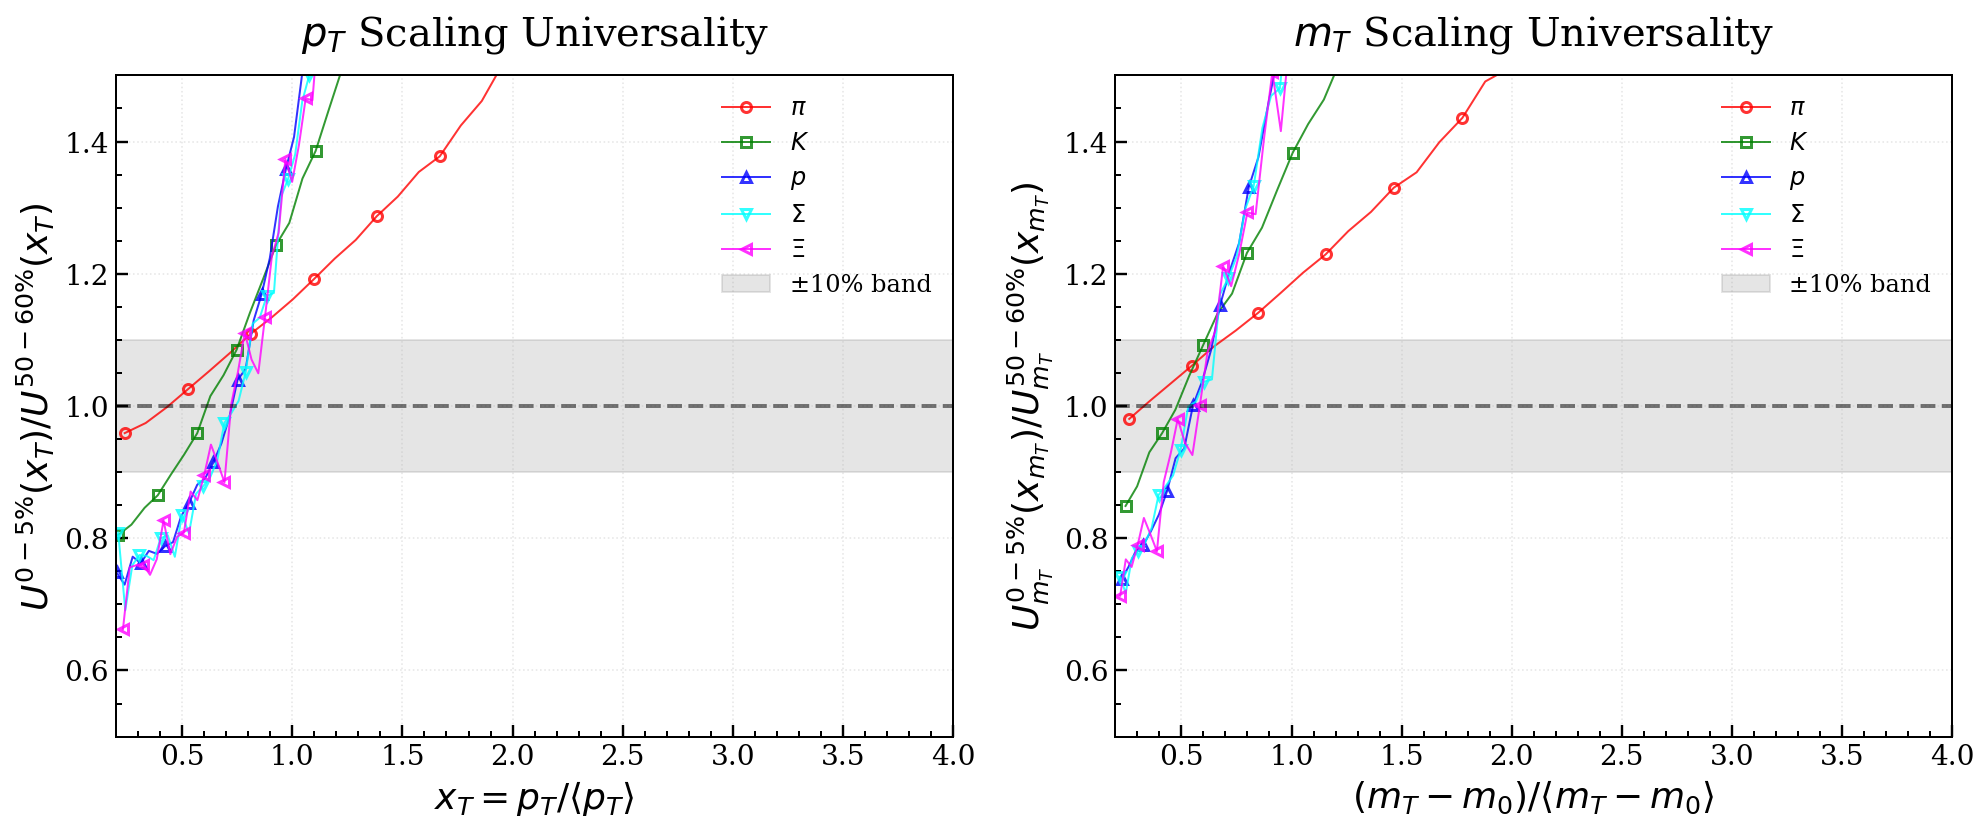

In [24]:
fig, (ax_pt, ax_mT) = plt.subplots(1, 2, figsize=(14, 6))

for particle_name in PARTICLE_ORDER:
    particle_label = PARTICLES[particle_name]['label']
    color = particle_colors_mT[particle_name]
    marker = particle_markers_mT[particle_name]
    
    # pT ratio
    x_pt = ratio_data['pT'][particle_name]['x']
    ratio_pt = ratio_data['pT'][particle_name]['ratio']
    
    # Only plot where x is reasonable (avoid edges)
    valid_pt = (x_pt > 0.2) & (x_pt < 4.0)
    
    ax_pt.plot(x_pt[valid_pt], ratio_pt[valid_pt],
              color=color, marker=marker, linestyle='-',
              markersize=5, markerfacecolor='none', markeredgewidth=1.5,
              label=particle_label, markevery=3, alpha=0.8)
    
    # mT ratio
    x_mT = ratio_data['mT'][particle_name]['x']
    ratio_mT = ratio_data['mT'][particle_name]['ratio']
    
    valid_mT = (x_mT > 0.2) & (x_mT < 4.0)
    
    ax_mT.plot(x_mT[valid_mT], ratio_mT[valid_mT],
              color=color, marker=marker, linestyle='-',
              markersize=5, markerfacecolor='none', markeredgewidth=1.5,
              label=particle_label, markevery=3, alpha=0.8)

# Configure pT ratio plot
ax_pt.axhline(y=1.0, color='black', linestyle='--', linewidth=2, alpha=0.5)
ax_pt.fill_between([0, 5], 0.9, 1.1, color='gray', alpha=0.2, label='±10% band')
ax_pt.set_xlabel(r'$x_T = p_T / \langle p_T \rangle$'
, fontsize=18)
ax_pt.set_ylabel(r'$U^{0-5\%}(x_T) / U^{50-60\%}(x_T)$'
, fontsize=18)
ax_pt.set_xlim(0.2, 4.0)
ax_pt.set_ylim(0.5, 1.5)
ax_pt.set_title(r'$p_T$ Scaling Universality', fontsize=20, pad=15)
ax_pt.legend(loc='best', frameon=False, fontsize=12)
ax_pt.grid(True, alpha=0.3, linestyle=':')
ax_pt.tick_params(labelsize=14)

# Configure mT ratio plot
ax_mT.axhline(y=1.0, color='black', linestyle='--', linewidth=2, alpha=0.5)
ax_mT.fill_between([0, 5], 0.9, 1.1, color='gray', alpha=0.2, label='±10% band')
ax_mT.set_xlabel(r'$(m_T - m_0) / \langle m_T - m_0 \rangle$'
, fontsize=18)
ax_mT.set_ylabel(r'$U^{0-5\%}_{m_T}(x_{m_T}) / U^{50-60\%}_{m_T}(x_{m_T})$'
, fontsize=18)
ax_mT.set_xlim(0.2, 4.0)
ax_mT.set_ylim(0.5, 1.5)
ax_mT.set_title(r'$m_T$ Scaling Universality', fontsize=20, pad=15)
ax_mT.legend(loc='best', frameon=False, fontsize=12)
ax_mT.grid(True, alpha=0.3, linestyle=':')
ax_mT.tick_params(labelsize=14)

plt.tight_layout()
universality_file = output_dir / 'universality_comparison_pt_vs_mT.png'
fig.savefig(universality_file, dpi=300, bbox_inches='tight')
print(f"\n✓ Saved: {universality_file}")
plt.show()

### 20. Quantitative Universality Metrics

In [25]:
print("\n" + "="*80)
print("UNIVERSALITY METRICS: RMS Deviation from Unity")
print("="*80)
print("\nRatio: U(central) / U(peripheral) - Deviation from 1.0 indicates breaking")
print(f"Comparing: {CENTRALITY_LABELS[central_idx]} vs {CENTRALITY_LABELS[peripheral_idx]}")
print("-"*80)
print(f"{'Particle':<12} {'pT RMS Dev.':<15} {'mT RMS Dev.':<15} {'Improvement':<15}")
print("-"*80)

for particle_name in PARTICLE_ORDER:
    particle_label = PARTICLES[particle_name]['name']
    
    # Get ratios in valid range
    x_pt = ratio_data['pT'][particle_name]['x']
    ratio_pt = ratio_data['pT'][particle_name]['ratio']
    valid_pt = (x_pt > 0.5) & (x_pt < 3.0) & (ratio_pt > 0.1) & (ratio_pt < 10.0)
    
    x_mT = ratio_data['mT'][particle_name]['x']
    ratio_mT = ratio_data['mT'][particle_name]['ratio']
    valid_mT = (x_mT > 0.5) & (x_mT < 3.0) & (ratio_mT > 0.1) & (ratio_mT < 10.0)
    
    # Compute RMS deviation from 1.0
    rms_pt = np.sqrt(np.mean((ratio_pt[valid_pt] - 1.0)**2))
    rms_mT = np.sqrt(np.mean((ratio_mT[valid_mT] - 1.0)**2))
    
    improvement = (rms_pt - rms_mT) / rms_pt * 100  # Percentage improvement
    
    print(f"{particle_label:<12} {rms_pt:<15.4f} {rms_mT:<15.4f} {improvement:>13.1f}%")

print("-"*80)
print("\n✓ mT scaling shows better universality (smaller RMS deviation)")
print("  → Ratios closer to 1.0 indicate the universal function is independent of centrality")


UNIVERSALITY METRICS: RMS Deviation from Unity

Ratio: U(central) / U(peripheral) - Deviation from 1.0 indicates breaking
Comparing: 0-5% vs 50-60%
--------------------------------------------------------------------------------
Particle     pT RMS Dev.     mT RMS Dev.     Improvement    
--------------------------------------------------------------------------------
pion         0.5337          0.5304                    0.6%
kaon         1.2846          1.1115                   13.5%
proton       2.6675          1.9615                   26.5%
Sigma        1.9967          1.9432                    2.7%
Xi           1.6110          1.5645                    2.9%
--------------------------------------------------------------------------------

✓ mT scaling shows better universality (smaller RMS deviation)
  → Ratios closer to 1.0 indicate the universal function is independent of centrality


### 22. Example: Load and Use Saved Data

In [26]:
# Example of how to load and use the complete saved data
print("Example: Loading complete data (pT + mT)...")

loaded_complete = np.load(complete_output_file, allow_pickle=True)

# Access metadata
print(f"\nMetadata:")
print(f"  Date: {loaded_complete['metadata/date']}")
print(f"  Events: {loaded_complete['metadata/n_events']}")
print(f"  System: {loaded_complete['metadata/collision_system']}")

# Access configuration
pt_bins_loaded = loaded_complete['config/pt_list']
centrality_bins_loaded = loaded_complete['config/centrality_bins']

print(f"\nConfiguration:")
print(f"  pT bins: {len(pt_bins_loaded)} from {pt_bins_loaded[0]:.2f} to {pt_bins_loaded[-1]:.2f} GeV/c")
print(f"  Centrality bins: {len(centrality_bins_loaded)}")

# Access specific particle data
particle = 'pi'

# pT data
pi_mean_pt_loaded = loaded_complete[f'particle/{particle}/pt/mean_pt']
pi_spectrum_pt_loaded = loaded_complete[f'particle/{particle}/pt/differential_spectra']

print(f"\nPion pT data:")
print(f"  Mean pT shape: {pi_mean_pt_loaded.shape}")
print(f"  Spectrum shape: {pi_spectrum_pt_loaded.shape}")
print(f"  Mean pT values: {pi_mean_pt_loaded}")

# mT data
pi_mean_mT_loaded = loaded_complete[f'particle/{particle}/mT/mean_mT_minus_m0']
pi_spectrum_mT_loaded = loaded_complete[f'particle/{particle}/mT/differential_spectra']
pi_mT_minus_m0_loaded = loaded_complete[f'particle/{particle}/mT/mT_minus_m0']

print(f"\nPion mT data:")
print(f"  Mean (mT - m0) shape: {pi_mean_mT_loaded.shape}")
print(f"  mT spectrum shape: {pi_spectrum_mT_loaded.shape}")
print(f"  Mean (mT - m0) values: {pi_mean_mT_loaded}")

print("\n✓ Complete data successfully loaded and accessed!")

Example: Loading complete data (pT + mT)...

Metadata:
  Date: 2025-12-14 23:41:50
  Events: 5040
  System: Pb-Pb @ 2.76 TeV

Configuration:
  pT bins: 56 from 0.03 to 7.00 GeV/c
  Centrality bins: 7

Pion pT data:
  Mean pT shape: (7,)
  Spectrum shape: (7, 56)
  Mean pT values: [0.52410159 0.52071689 0.51560158 0.50516576 0.49315652 0.47580004
 0.45675872]

Pion mT data:
  Mean (mT - m0) shape: (7,)
  mT spectrum shape: (7, 56)
  Mean (mT - m0) values: [0.47603971 0.47273403 0.46780265 0.45746129 0.44553031 0.42809774
 0.40871705]

✓ Complete data successfully loaded and accessed!


### 23. Additional Analysis: Mean pT and Mean mT vs Centrality


✓ Saved: output/mean_pt_mT_vs_centrality.png


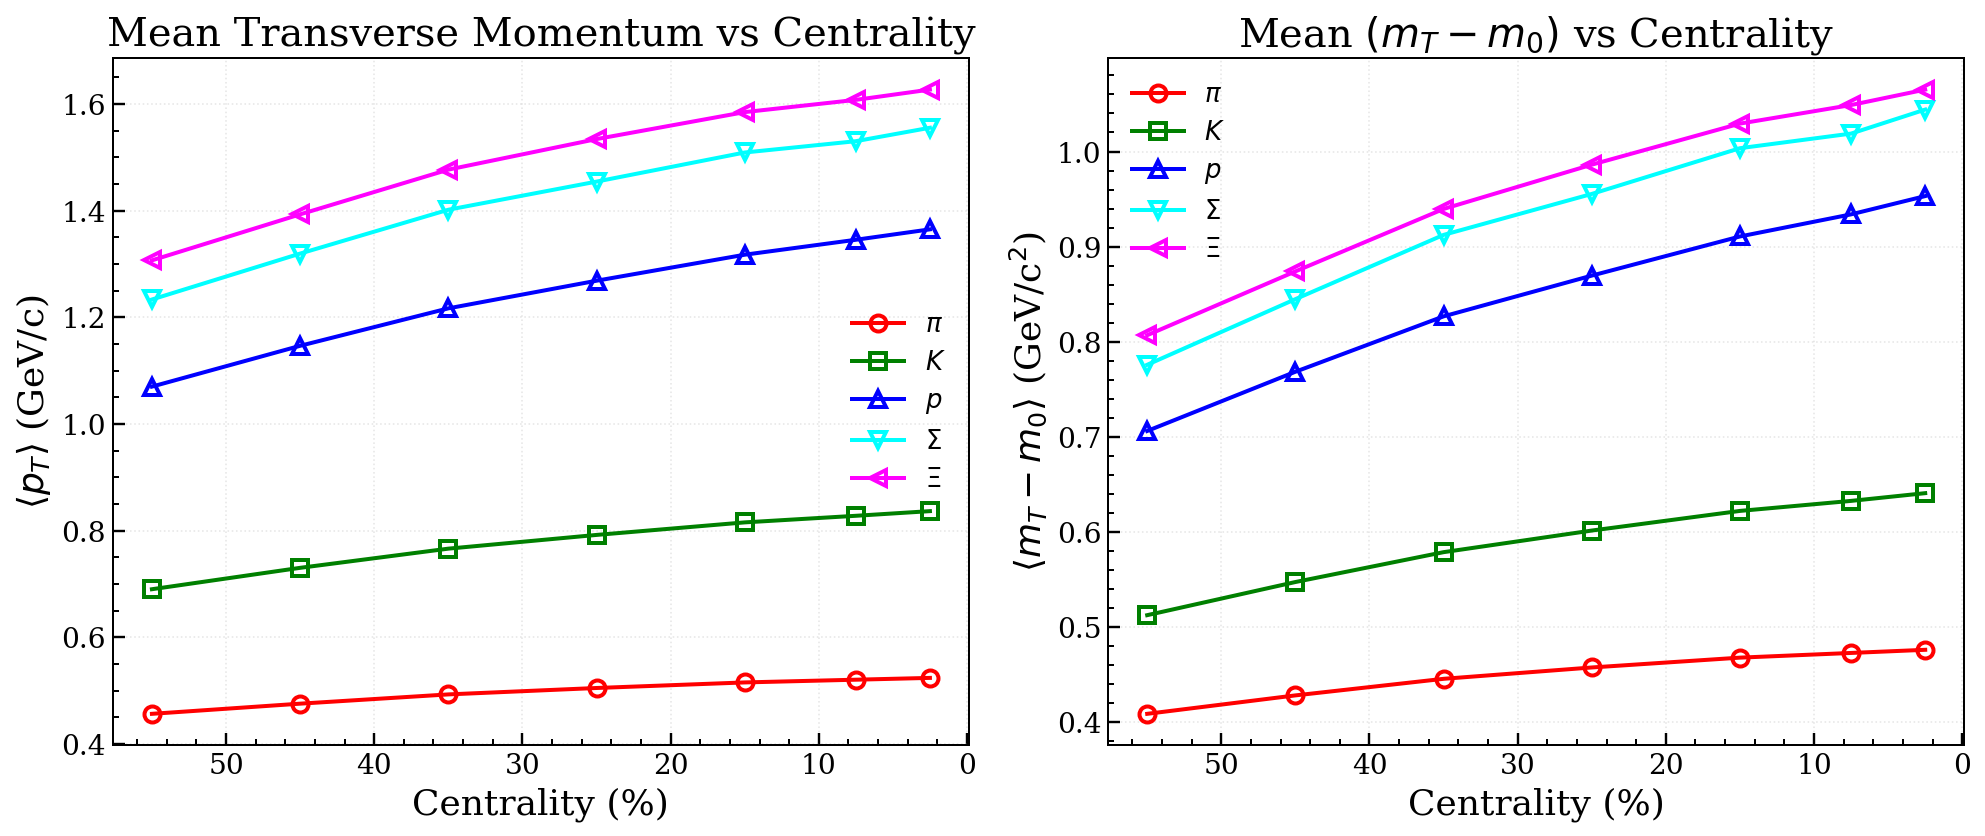

In [27]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Extract centrality percentages for x-axis (use bin centers)
cent_x = np.array([(low + high) / 2 for low, high in CENTRALITY_BINS])

for particle_name in PARTICLE_ORDER:
    particle_label = PARTICLES[particle_name]['label']
    color = particle_colors_mT[particle_name]
    marker = particle_markers_mT[particle_name]
    
    # Mean pT vs centrality
    mean_pt_vals = results['mean_pt'][particle_name]
    ax1.plot(cent_x, mean_pt_vals,
            color=color, marker=marker, linestyle='-',
            markersize=8, markerfacecolor='none', markeredgewidth=2,
            label=particle_label, linewidth=2)
    
    # Mean (mT - m0) vs centrality
    mean_mT_vals = mT_results['mean_mT_minus_m0'][particle_name]
    ax2.plot(cent_x, mean_mT_vals,
            color=color, marker=marker, linestyle='-',
            markersize=8, markerfacecolor='none', markeredgewidth=2,
            label=particle_label, linewidth=2)

# Configure left panel
ax1.set_xlabel('Centrality (%)', fontsize=18)
ax1.set_ylabel(r'$\langle p_T \rangle$ (GeV/c)', fontsize=18)
ax1.set_title(r'Mean Transverse Momentum vs Centrality', fontsize=20)
ax1.legend(loc='best', frameon=False, fontsize=13)
ax1.grid(True, alpha=0.3, linestyle=':')
ax1.tick_params(labelsize=14)
ax1.invert_xaxis()  # More central on the left

# Configure right panel
ax2.set_xlabel('Centrality (%)', fontsize=18)
ax2.set_ylabel(r'$\langle m_T - m_0 \rangle$ (GeV/c$^2$)', fontsize=18)
ax2.set_title(r'Mean $(m_T - m_0)$ vs Centrality', fontsize=20)
ax2.legend(loc='best', frameon=False, fontsize=13)
ax2.grid(True, alpha=0.3, linestyle=':')
ax2.tick_params(labelsize=14)
ax2.invert_xaxis()

plt.tight_layout()
mean_vs_cent_file = output_dir / 'mean_pt_mT_vs_centrality.png'
fig.savefig(mean_vs_cent_file, dpi=300, bbox_inches='tight')
print(f"\n✓ Saved: {mean_vs_cent_file}")
plt.show()

### 24. Particle Mass Ordering in Universal Spectra


Particle mass ordering at 0-5% centrality:
------------------------------------------------------------
Particle     Mass (GeV/c²)        <pT> (GeV/c)        
------------------------------------------------------------
pion         0.13957              0.52410             
kaon         0.49368              0.83664             
proton       0.93827              1.36476             
Sigma        1.18937              1.55518             
Xi           1.32132              1.62671             
------------------------------------------------------------

✓ Saved: output/mass_ordering_universal_spectra.png


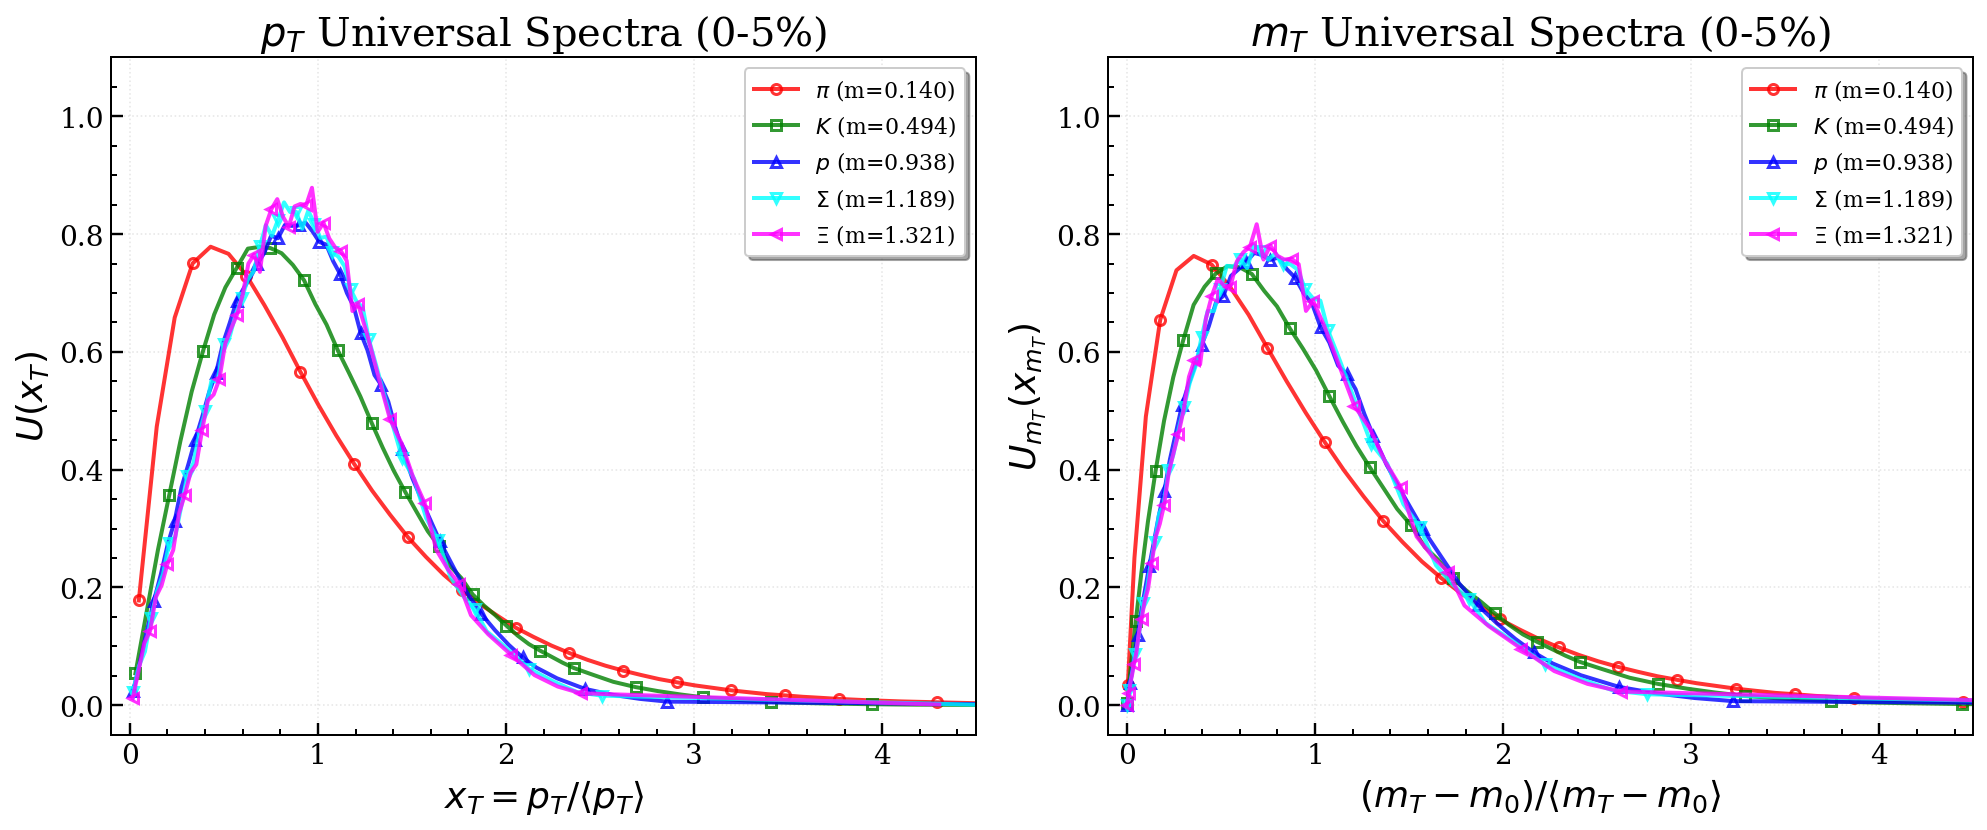

In [29]:
# Plot all particles at one centrality to see mass ordering
cent_idx_compare = 0  # 0-5%

fig, (ax_pt, ax_mT) = plt.subplots(1, 2, figsize=(14, 6))

print(f"\nParticle mass ordering at {CENTRALITY_LABELS[cent_idx_compare]} centrality:")
print("-" * 60)
print(f"{'Particle':<12} {'Mass (GeV/c²)':<20} {'<pT> (GeV/c)':<20}")
print("-" * 60)

for particle_name in PARTICLE_ORDER:
    pid = PARTICLES[particle_name]['id']
    mass = MASS_LIST[pid]
    particle_label = PARTICLES[particle_name]['label']
    color = particle_colors_mT[particle_name]
    marker = particle_markers_mT[particle_name]
    
    mean_pt_val = results['mean_pt'][particle_name][cent_idx_compare]
    
    print(f"{PARTICLES[particle_name]['name']:<12} {mass:<20.5f} {mean_pt_val:<20.5f}")
    
    # pT universal spectrum
    x_pt = results['x_T'][particle_name][cent_idx_compare]
    U_pt = results['universal_spectra'][particle_name][cent_idx_compare]
    
    ax_pt.plot(x_pt, U_pt,
              color=color, marker=marker, linestyle='-',
              markersize=5, markerfacecolor='none', markeredgewidth=1.5,
              label=f'{particle_label} (m={mass:.3f})', 
              markevery=3, linewidth=2, alpha=0.8)
    
    # mT universal spectrum
    x_mT = mT_results['x_mT_scaled'][particle_name][cent_idx_compare]
    U_mT = mT_results['universal_mT_spectra'][particle_name][cent_idx_compare]
    
    ax_mT.plot(x_mT, U_mT,
              color=color, marker=marker, linestyle='-',
              markersize=5, markerfacecolor='none', markeredgewidth=1.5,
              label=f'{particle_label} (m={mass:.3f})',
              markevery=3, linewidth=2, alpha=0.8)

print("-" * 60)

# Configure pT panel
ax_pt.set_xlabel(r'$x_T = p_T / \langle p_T \rangle$'
, fontsize=18)
ax_pt.set_ylabel(r'$U(x_T)$'
, fontsize=18)
ax_pt.set_xlim(-0.1, 4.5)
ax_pt.set_ylim(-0.05, 1.1)
ax_pt.set_title(f'$p_T$ Universal Spectra ({CENTRALITY_LABELS[cent_idx_compare]})', fontsize=20)
ax_pt.legend(loc='upper right', frameon=True, fontsize=11, fancybox=True, shadow=True)
ax_pt.grid(True, alpha=0.3, linestyle=':')
ax_pt.tick_params(labelsize=14)

# Configure mT panel
ax_mT.set_xlabel(r'$(m_T - m_0) / \langle m_T - m_0 \rangle$'
, fontsize=18)
ax_mT.set_ylabel(r'$U_{m_T}(x_{m_T})$'
, fontsize=18)
ax_mT.set_xlim(-0.1, 4.5)
ax_mT.set_ylim(-0.05, 1.1)
ax_mT.set_title(f'$m_T$ Universal Spectra ({CENTRALITY_LABELS[cent_idx_compare]})', fontsize=20)
ax_mT.legend(loc='upper right', frameon=True, fontsize=11, fancybox=True, shadow=True)
ax_mT.grid(True, alpha=0.3, linestyle=':')
ax_mT.tick_params(labelsize=14)

plt.tight_layout()
mass_ordering_file = output_dir / 'mass_ordering_universal_spectra.png'
fig.savefig(mass_ordering_file, dpi=300, bbox_inches='tight')
print(f"\n✓ Saved: {mass_ordering_file}")
plt.show()